![Women and children first](http://www.titanicuniverse.com/wp-content/uploads/2009/10/titanic-sinking-lifeboats1.jpg)

<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>II. Titanic Exploratory
Data Analysis - EDA</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Prediction of survival rate using 9
variables</center></p>

For this analysis we use the <b>Titanic Kaggle Competition</b> dataset found on the Kaggle Data
Repository at the following location:

<a href=https://www.kaggle.com/c/titanic/data>Titanic Kaggle Competition Dataset</a>

The objective of the analysis is to classify passengers on the Titanic during the disaster
of 1912 according to survival

We aim to achieve this by following the ML pipeline approach of deploying a variety of ML
techniques to build a final predictive model with the highest possible accuracy. This
particular analysis comprises 4 notebooks as follows:

 1. <i>titanic_baseline</i> - Baseline predictive models (quick and dirty) to
 compare later results against
 2. <i>titanic_eda</i> - <b>This notebook</b>, Exploratory Descriptive Analysis (EDA)
 3. <i>titanic_features</i> - Perform feature engineering
 4. <i>titanic_final_model</i> - Final model

We hope to gain valuable insights by following this process. The various steps in the
process can be elaborated on as follows (the various notebooks will focus on different parts
 of the process as indicated):

- Load data (<i>all notebooks</i>)
- Prepare data
    - Clean data (<i>notebook 2</i>)
        - Missing values
        - Outliers
        - Erroneous values
    - Explore data (<i>notebook 2</i>)
        - Exploratory descriptive analysis (EDA)
        - Correlation analysis
        - Variable cluster analysis
    - Transform Data (<i>notebook 3</i>)
        - Engineer features
        - Encode data
        - Scale & normalise data
        - Impute data (if not done in previous steps)
        - Feature selection/ importance analysis
- Build model (<i>notebooks 1 & 4</i>)
    - Model selection
    - Data sampling (validation strategy, imbalanced classification)
    - Hyperparameter optimisation
- Validate model (<i>notebooks 1 & 4</i>)
    - Accuracy testing
- Analysis of results (<i>notebook 1 & 4</i>)
    - Response curves
    - Accuracy analysis
    - Commentary

The data dictionary for this dataset is as follows:

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival	| 0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | male, female |
|Age | Age in years | Continuous |
|sibsp | # of siblings / spouses aboard the Titanic | 0, 1, 2, ..|
|parch | # of parents / children aboard the Titanic | 0, 1, 2 ..|
|ticket | Ticket number | PC 17599, STON/O2. 3101282, 330877 |
|fare | Passenger fare | Continuous |
|cabin | Cabin number | C123, C85, E46 |
|embarked | Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Let us start the analysis for <b>notebook 2</b>!

This notebook follows on the previous notebook. We previously concluded that there is a very
 strong signal in the data, even without any pre-processing. We also found that
 several variables have potential for improving the model if pre-processed. The analysis
 also suggests that improvement could be gained by feature engineering. In this notebook we
 will gain an understanding of the data and consider ways of improving our existing score by
  re-doing our missing data imputation and performing feature engineering.

We will also learn more about the domain i.e. the events surrounding the accident.

We will perform an analysis on the entire training dataset i.e. 891 records. We will sense
check our findings against the test set to ensure the two are aligned. We will then make
some high level improvements to our models based on our findings and see if our accuracy
improves.

We start by discussing the data with domain experts, to build up an intuition about the data
. In my case I consulted the most knowledgeable person in our household regarding the matter
 i.e. my daughter whom has watched the movie several times. On asking her the question as to
  who the most likely people to survive the Titanic accident she came up with the following
  (without any hesitation or thought):

- The wealthier passengers, as they would have cabins on the higher decks, closer to the
lifeboats.
- Woman, children and older passengers, as at the time chivalry still existed, and it is
likely that able-bodied younger men would have assisted these passengers with evacuation
(which is not the case anymore today she however added :( ).
- She also stated that individuals working on the Titanic staying on the lower decks
were less likely to survive (which prompted me to think that these individuals probably also
 did not pay a fare, or at least a very low fare...).

This is a nice place to start! Let us see what the data says.

Also, to start off with, thank you to the following authors for the inspiration and ideas (and
some code:)) which I have obtained from your excellent work:

Gunes Evitan: https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

Ata Saygın Odabaşı: https://www.kaggle.com/atasaygin/titanic-randomforestclassifier-and-visualization (had to use your map!)

In [99]:
# Import libraries
from math import sqrt
from subprocess import call

import re
import patsy
import folium as folium
from folium import plugins
from folium.plugins import HeatMap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.core.display import Image
from matplotlib import pyplot
from mlens.ensemble import SuperLearner
from numpy import isnan
from patsy.highlevel import dmatrices, dmatrix
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.impute._iterative import IterativeImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, SVC
from sklearn.linear_model import ElasticNet
from statsmodels.tools.eval_measures import mse
from termcolor import cprint

from src.visualization.visualize_titanic import plot_confusion_matrix, plot_roc_curve, \
    plotVar, plotAge, plot_feature_importance, plot_feature_importance_dec, \
    plot_learning_curve, get_models, get_super_learner, pre_process_name, \
    pre_process_title, pre_process_surname
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, BaggingRegressor, \
    RandomForestRegressor, ExtraTreesRegressor, AdaBoostClassifier, BaggingClassifier, \
    ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, \
    validation_curve
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from pandasql import sqldf
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>Load Data</center></h1>

In [2]:
# Import data
df_train = pd.read_csv('../data/external/train.csv', header = None,
                       names = ['passenger_id', 'survived', 'p_class', 'name', 'sex', 'age',
                                'sib_sp', 'parch', 'ticket', 'fare', 'cabin', 'embarked'],
                       index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                       skiprows=1, sep=',', skipinitialspace=True)

#### Train Data

In [3]:
cprint('The training dataset looks as follows', 'green')
df_train.head(20)

cprint('The training dataset dimensions are', 'green')
print(df_train.shape)


The training dataset looks as follows


passenger_id  survived  p_class                                                     name     sex   age  sib_sp  parch            ticket     fare cabin embarked
0   1             0         3        Braund, Mr. Owen Harris                                  male    22.0  1       0      A/5 21171         7.2500   NaN   S      
1   2             1         1        Cumings, Mrs. John Bradley (Florence Briggs Thayer)      female  38.0  1       0      PC 17599          71.2833  C85   C      
2   3             1         3        Heikkinen, Miss. Laina                                   female  26.0  0       0      STON/O2. 3101282  7.9250   NaN   S      
3   4             1         1        Futrelle, Mrs. Jacques Heath (Lily May Peel)             female  35.0  1       0      113803            53.1000  C123  S      
4   5             0         3        Allen, Mr. William Henry                                 male    35.0  0       0      373450            8.0500   NaN   S      
5   6             0         3        Moran, Mr. James                                         male   NaN    0       0      330877            8.4583   NaN   Q      
6   7             0         1        McCarthy, Mr. Timothy J                                  male    54.0  0       0      17463             51.8625  E46   S      
7   8             0         3        Palsson, Master. Gosta Leonard                           male    2.0   3       1      349909            21.0750  NaN   S      
8   9             1         3        Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)        female  27.0  0       2      347742            11.1333  NaN   S      
9   10            1         2        Nasser, Mrs. Nicholas (Adele Achem)                      female  14.0  1       0      237736            30.0708  NaN   C      
10  11            1         3        Sandstrom, Miss. Marguerite Rut                          female  4.0   1       1      PP 9549           16.7000  G6    S      
11  12            1         1        Bonnell, Miss. Elizabeth                                 female  58.0  0       0      113783            26.5500  C103  S      
12  13            0         3        Saundercock, Mr. William Henry                           male    20.0  0       0      A/5. 2151         8.0500   NaN   S      
13  14            0         3        Andersson, Mr. Anders Johan                              male    39.0  1       5      347082            31.2750  NaN   S      
14  15            0         3        Vestrom, Miss. Hulda Amanda Adolfina                     female  14.0  0       0      350406            7.8542   NaN   S      
15  16            1         2        Hewlett, Mrs. (Mary D Kingcome)                          female  55.0  0       0      248706            16.0000  NaN   S      
16  17            0         3        Rice, Master. Eugene                                     male    2.0   4       1      382652            29.1250  NaN   Q      
17  18            1         2        Williams, Mr. Charles Eugene                             male   NaN    0       0      244373            13.0000  NaN   S      
18  19            0         3        Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)  female  31.0  1       0      345763            18.0000  NaN   S      
19  20            1         3        Masselmani, Mrs. Fatima                                  female NaN    0       0      2649              7.2250   NaN   C

The training dataset dimensions are
(891, 12)


In [4]:
# Import data
df_test = pd.read_csv('../data/external/test.csv', header = None,
                      names = ['passenger_id', 'p_class', 'name', 'sex', 'age', 'sib_sp',
                               'parch', 'ticket', 'fare', 'cabin', 'embarked'],
                      index_col=False, usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                      skiprows=1, sep=',', skipinitialspace=True)

#### Test Data

In [5]:
cprint('The test dataset looks as follows', 'green')
df_test.head(20)

cprint('The test dataset dimensions are', 'green')
print(df_test.shape)
df_orig = df_test.copy()

The test dataset looks as follows


passenger_id  p_class                                                     name     sex   age  sib_sp  parch            ticket     fare cabin embarked
0   892           3        Kelly, Mr. James                                         male    34.5  0       0      330911            7.8292   NaN   Q      
1   893           3        Wilkes, Mrs. James (Ellen Needs)                         female  47.0  1       0      363272            7.0000   NaN   S      
2   894           2        Myles, Mr. Thomas Francis                                male    62.0  0       0      240276            9.6875   NaN   Q      
3   895           3        Wirz, Mr. Albert                                         male    27.0  0       0      315154            8.6625   NaN   S      
4   896           3        Hirvonen, Mrs. Alexander (Helga E Lindqvist)             female  22.0  1       1      3101298           12.2875  NaN   S      
5   897           3        Svensson, Mr. Johan Cervin                               male    14.0  0       0      7538              9.2250   NaN   S      
6   898           3        Connolly, Miss. Kate                                     female  30.0  0       0      330972            7.6292   NaN   Q      
7   899           2        Caldwell, Mr. Albert Francis                             male    26.0  1       1      248738            29.0000  NaN   S      
8   900           3        Abrahim, Mrs. Joseph (Sophie Halaut Easu)                female  18.0  0       0      2657              7.2292   NaN   C      
9   901           3        Davies, Mr. John Samuel                                  male    21.0  2       0      A/4 48871         24.1500  NaN   S      
10  902           3        Ilieff, Mr. Ylio                                         male   NaN    0       0      349220            7.8958   NaN   S      
11  903           1        Jones, Mr. Charles Cresson                               male    46.0  0       0      694               26.0000  NaN   S      
12  904           1        Snyder, Mrs. John Pillsbury (Nelle Stevenson)            female  23.0  1       0      21228             82.2667  B45   S      
13  905           2        Howard, Mr. Benjamin                                     male    63.0  1       0      24065             26.0000  NaN   S      
14  906           1        Chaffee, Mrs. Herbert Fuller (Carrie Constance Toogood)  female  47.0  1       0      W.E.P. 5734       61.1750  E31   S      
15  907           2        del Carlo, Mrs. Sebastiano (Argenia Genovesi)            female  24.0  1       0      SC/PARIS 2167     27.7208  NaN   C      
16  908           2        Keane, Mr. Daniel                                        male    35.0  0       0      233734            12.3500  NaN   Q      
17  909           3        Assaf, Mr. Gerios                                        male    21.0  0       0      2692              7.2250   NaN   C      
18  910           3        Ilmakangas, Miss. Ida Livija                             female  27.0  1       0      STON/O2. 3101270  7.9250   NaN   S      
19  911           3        Assaf Khalil, Mrs. Mariana (Miriam")"                    female  45.0  0       0      2696              7.2250   NaN   C

The test dataset dimensions are
(418, 11)


We will peform our analysis as follows:

- Missing data checks.
- Model accuracy check.
- EDA (without missing data replacement).
- Variable adjustments & missing value imputation.
- Model accuracy check

First thing we will attend to is to bring the data we ignored in the first round, back into our
dataset i.e. name, ticket and cabin.



<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>Exploration of data - EDA
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Building up an understanding of the
data</center></p>


We start by looking at the number of unique records per variable.

In [6]:
print(df_train.nunique())

passenger_id    891
survived        2  
p_class         3  
name            891
sex             2  
age             88 
sib_sp          7  
parch           7  
ticket          681
fare            248
cabin           147
embarked        3  
dtype: int64


There are no columns with only one value. We therefore retain all columns for ML purposes as there is
enough variability to warrant using the data. There are many variables with fewer than 10 levels which
could be considered as categorical. Based on our initial assessment of the data we will work with
levels of measurement for the data as follows:

- p_class (ordinal) - we will revisit type of encoding later
- sex (binary) - recode (female - yes or no)
- age (continuous)
- sib_sp (ordinal) - check correlation - revisit encoding
- parch (ordinal) - check correlation - revisit encoding
- fare (continuous)
- embarked (nominal) - recode (one hot encode) - probably categorical

We start by separating continuous and categorical variables for further high level analysis.

In [7]:
# We will use datasets for this analysis as follows:
# df_train, df_test:                Original data, supplemented with extra fields e.g.
#                                   missing values.
# df_train_con*, df_train_cat*:     Datasets used for plotting continuous and categorical
#                                   variables.
# df_train_trans*, df_test_trans*:  Transformed data, as result of enrichment/ wrangling/
#                                   feature engineering.
# X, y, X_train, X_test:            Training and testing sets.

# Separate continuous and categorical variables
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')
names_cat = ('survived', 'p_class', 'sex', 'sib_sp', 'parch', 'embarked')
names_cat_test = ('p_class', 'sex', 'sib_sp', 'parch', 'embarked')
names_all_orig = ('survived', 'p_class', 'sex', 'sib_sp', 'parch', 'embarked', 'fare', 'age')

df_train_con = df_train.loc[:, names_con]
df_train_con_plot = df_train.loc[:, names_con_plot]
df_train_cat = df_train.loc[:, names_cat]

df_test_con = df_test.loc[:, names_con]
df_test_cat = df_test.loc[:, names_cat_test]

# Plotting label dictionary
plot_con = [('fare', 'Fare'),
            ('age', 'Age')]
plot_con_plot = [('survived', 'Survived'),
            ('fare', 'Fare'),
            ('age', 'Age')]
plot_cat = {'survived': ['Died', 'Survived'],
            'p_class': ['3rd', '1st', '2nd'],
            'sex': ['Male', 'Female'],
            'sib_sp': ['0', '1', '2', '4', '3', '8', '5'],
            'parch': ['0', '1', '2', '3', '5', '4', '6'],
            'embarked': ['Southampton', 'Cherbourg', 'Queenstown']}
plot_cat_plot = {'survived': 'Survival Rate',
            'p_class': 'Passenger Class Travelled',
            'sex': 'Gender',
            'sib_sp': '# Siblings or spouses',
            'parch': '# Parents or children',
            'embarked': 'Port of Embarkation'}

### High level overview


We observe that we have two candidates for continuous variables here (age and fare). With all the
categorical variables present, it is likely that a tree model would be better suited to this problem
unless significant feature engineering on categorical features is performed to ensure features are
optimally encoded, transformed and scaled for a linear model or neural network.

Let's continue with the high level analysis.

The overall survival rate was as follows (based on the training dataset):

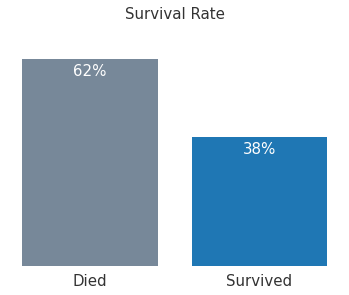

In [8]:
_ = plt.figure()

# Plot outcome counts.a
outcome_counts = df_train_cat['survived'].value_counts(normalize = True)
legend_labels = ['Died', 'Survived']

# change the background bar colors to be light grey
bars = plt.bar(outcome_counts.index, outcome_counts.values, align='center', linewidth=0,
               color='lightslategrey')
# make one bar, the survived bar, a contrasting color
bars[1].set_color('#1F77B4')

# soften all labels by turning grey
_ = plt.xticks(outcome_counts.index, legend_labels, fontsize=15, alpha=0.8)
_ = plt.title('Survival Rate', fontsize=15, pad=30, alpha=0.8)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Remove the frame - my method
ax = plt.gca()
ax.set_frame_on(False)

# Remove the frame of the chart - instructor's method
#for spine in plt.gca().spines.values():
#    spine.set_visible(False)

# direct label each bar with Y axis values
for bar in bars:
    _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                       str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                       fontsize=15)

plt.show()

The survival statistics are as follows:


In [9]:
print(df_train_cat['survived'].value_counts())
print("\n")

#print(df_train_cat['survived'].value_counts(normalize = True).mul(100).round(1).astype(str) + '%')
#print("\n")
#

0    549
1    342
Name: survived, dtype: int64




We observe that 38% of passengers survived and 62% died. These statistics correspond with the narrative on survival
rate quoted in the background information on Kaggle. There it is quoted that around 32% survived and 68% died. The
sample we are working with is thus representative of the overall population, which is important to note.

We observe that the target variable contains unbalanced classes. We need to consider revisiting the unbalanced
classes at a later stage - depending on the accuracy of our models. For now, we will forge ahead.

Next we will consider class level counts for categorical variables.

#### Categorical variable overview

Class percentages:

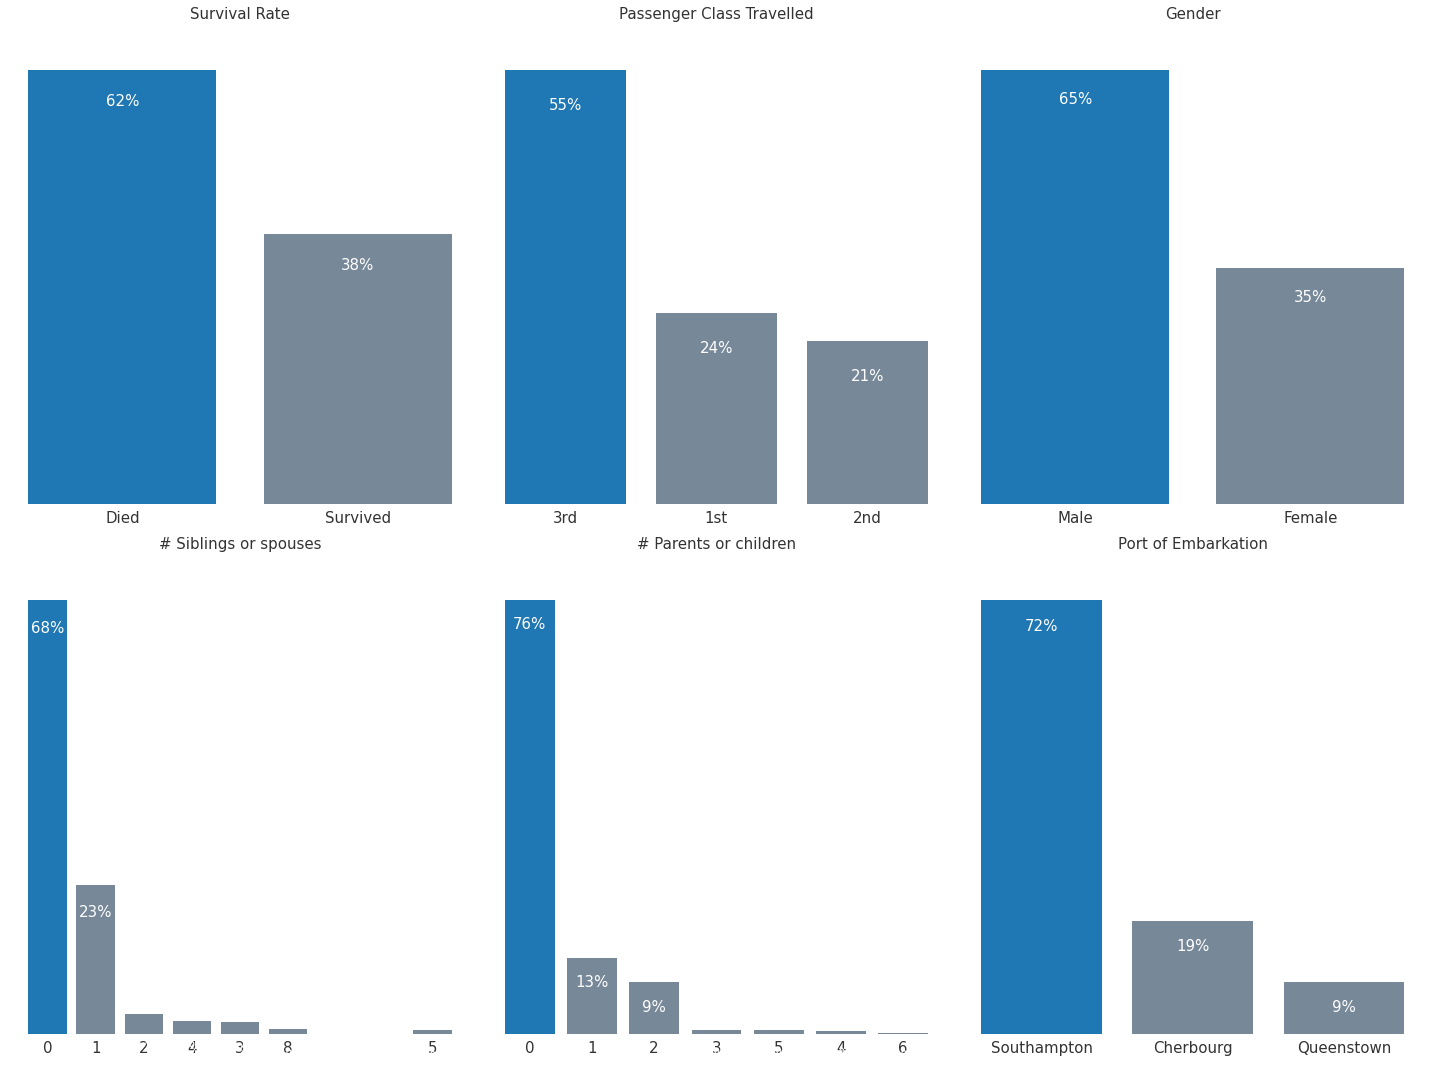

In [10]:
# Bar chart plot of categorical variables.
fig, ax = plt.subplots(2, 3, figsize=(20, 15));
base_color = '#1F77B4'
for variable, subplot in zip(names_cat, ax.flatten()):
    subplot.xaxis.label.set_size(24)
    subplot.yaxis.label.set_size(24)
    subplot.tick_params('y', labelsize = 20);
    subplot.tick_params('x', labelsize = 20);
    subplot.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                        labelbottom=True)
    subplot.set_frame_on(False)

    outcome_counts = df_train_cat[variable].value_counts(normalize=True)
    bars = subplot.bar(outcome_counts.index.sort_values(), outcome_counts.values, align='center',
                       linewidth=0,
               color='lightslategrey')
    # make one bar, the highest value bar, a contrasting color
    bars[0].set_color('#1F77B4')

    plt.sca(subplot)
    _ = plt.xticks(outcome_counts.index.sort_values(), plot_cat[variable], fontsize=15, alpha=0.8)
    _ = plt.title(plot_cat_plot[variable], fontsize=15, pad=30, alpha=0.8)

    # direct label each bar with Y axis values
    for bar in bars:
        _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                           str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                           fontsize=15)

    plt.tight_layout()


Class counts:

In [11]:
# Class level counts for categorical variables.
for variable in names_cat:
    #print(df_train_cat[variable].value_counts(normalize = True).mul(100).round(1).astype(str) +
    # '%')
    print(df_train_cat[variable].value_counts())
    print("\n")

0    549
1    342
Name: survived, dtype: int64


3    491
1    216
2    184
Name: p_class, dtype: int64


male      577
female    314
Name: sex, dtype: int64


0    608
1    209
2    28 
4    18 
3    16 
8    7  
5    5  
Name: sib_sp, dtype: int64


0    678
1    118
2    80 
3    5  
5    5  
4    4  
6    1  
Name: parch, dtype: int64


S    644
C    168
Q    77 
Name: embarked, dtype: int64




From the categorical variables we observe that there were approximately twice as many passengers in class 3 than either
class 1 or 2. We also observe that there were nearly twice as many males as females on the Titanic. We also observe
that more than two thirds of passengers did not have any siblings on board. Likewise we observe that more than two
thirds did not have a father or child on board.

It is therefore fair to say that the majority of passengers were either couples or single travellers without children
. In the case where families did travel, the majority of families had one or two children. Very few families with
more children were on board the Titanic.

Many of these variables could contribute to correlation with survival at face value e.g. it
stands to reason that preference would have been given in lifeboats to women and children,
and that more affluent travellers would have had access to better lifeboats. We will however
 test these hypotheses in this analysis.

We also see that more than two thirds of passengers departed from Southampton. The relative
distribution between the different ports can be observed from the following heatmap.

In [12]:
count_towns = df_train_cat.groupby(
    pd.Grouper(key='embarked')).size().reset_index(name='count')

latitude_embark = ['50.897', '49.6423', ' 51.84914']
longitude_embark = ['-1.404', '-1.62551', '-8.2975265']

count_towns['latitude_embark'] = latitude_embark
count_towns['longitude_embark'] = longitude_embark

m = folium.Map([49.922935, -6.068136], zoom_start=6, width='%100', height='%100')

heat_data = count_towns.groupby(["latitude_embark", "longitude_embark"])['count'].mean().reset_index().values.tolist()
_ = folium.plugins.HeatMap(heat_data).add_to(m)
m

#### Continuous variable overview

We start by considering the age distribution of the passengers. At this point we do some limited
EDA in that we will consider the age profiles of those who survived vs. those who died. As with
many natural phenomena we expect age to have some influence on mortality.

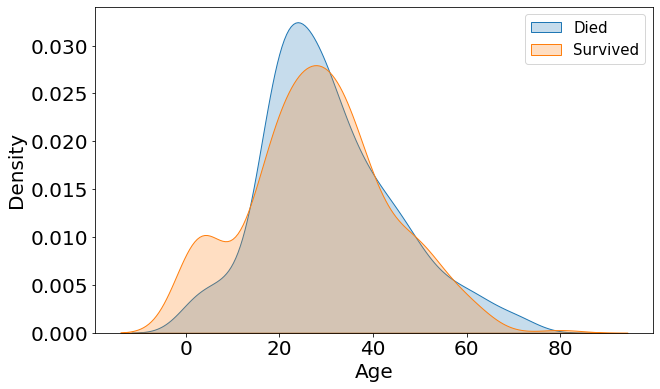

In [13]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), squeeze=False)

_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 0), 'age'], shade =
True, label = 'Died')
_ = sns.kdeplot(data=df_train_con_plot.loc[(df_train_con_plot['survived'] == 1), 'age'], shade =
True, label = 'Survived')
_ = plt.xlabel('Age', fontsize=20)
_ = plt.ylabel('Density', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
_ = plt.legend(fontsize=15)
plt.show()


From the age distribution plot we can see that more children under the age of 15 survived than
died in the incident. We can see that more individuals between the ages of 20 and 40 died than
survived. We can also see that more individuals above the age of 80 survived compared to dying.

We can also see that the majority of individuals on the cruise were between the ages of 20 to 40.
There were fewer teenagers compared to children under 10. There were comparatively fewer elderly
people on board i.e. above 60.

In [14]:
# 5 number summary.
df_train_con.describe()


fare         age
count  891.000000  714.000000
mean   32.204208   29.699118 
std    49.693429   14.526497 
min    0.000000    0.420000  
25%    7.910400    20.125000 
50%    14.454200   28.000000 
75%    31.000000   38.000000 
max    512.329200  80.000000

We now consider the fare distribution too. As with age, our assumption would be that fare has a
correlation with mortality too.

The fare distribution is severely skewed to the right. The kurtosis of the plot is very high with
 most values clustered closely around the median value of 14. There was a non-significant but
 relatively smaller number of fares spread between teh values of 30 and 500.

The age distribution was as previously discussed, with a minimum of 6 months and maximum of 80
years old. The distribution is fairly symmetrical with a slight skew to the right. There is a
young child bump to the left of the distribution.

We now do a more in depth visual analysis of the correlation between survival and fare and age
respectively. We do this by creating a set of Violin plots.

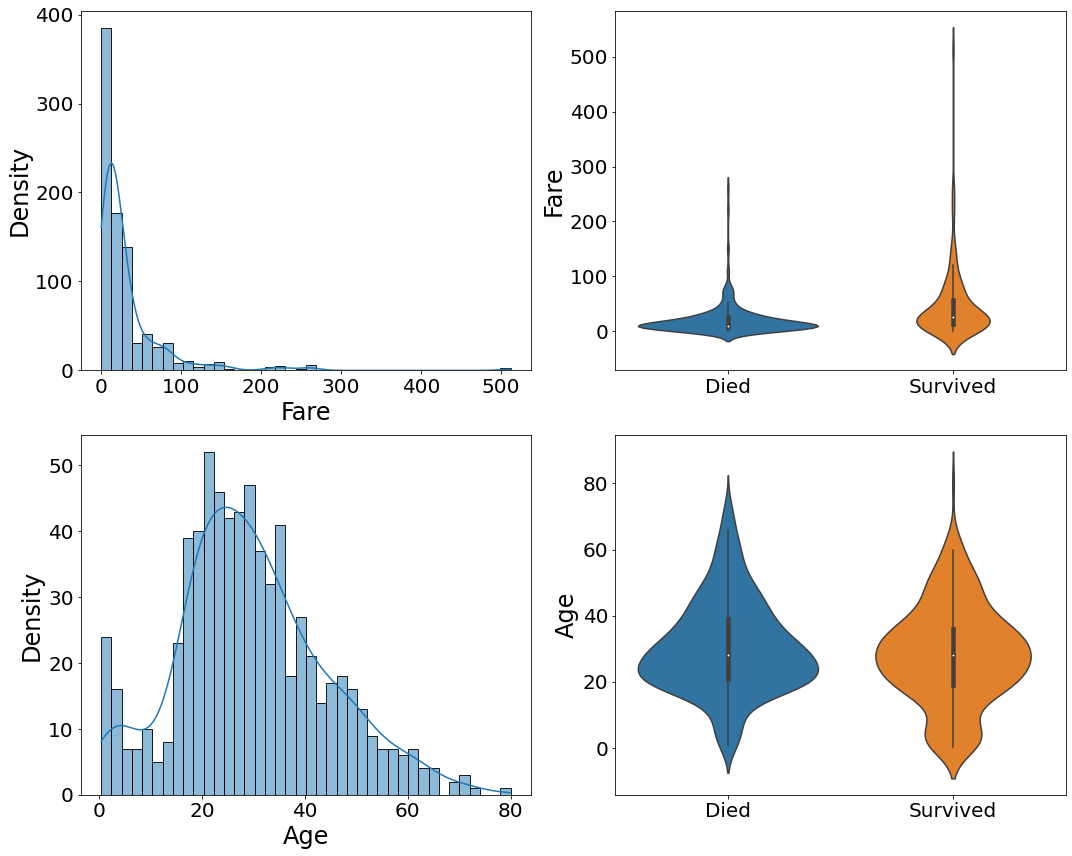

In [15]:
# Continuous density plot
fig_continuous, axes = plt.subplots(nrows=len(names_con_plot)-1, ncols=2, figsize=(15, 12))

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[0][0], kde=True, data=df_train_con_plot, ax=axes[0][0], bins=40);
_ = axes[0][0].set(xlabel=plot_con[0][1], ylabel='Density');
axes[0][0].xaxis.label.set_size(24)
axes[0][0].yaxis.label.set_size(24)
axes[0][0].tick_params('y', labelsize = 20);
axes[0][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[0][0], data=df_train_con_plot, ax=axes[0][1]);
_ = axes[0][1].set(xlabel='', ylabel=plot_con[0][1]);
axes[0][1].xaxis.label.set_size(24)
axes[0][1].yaxis.label.set_size(24)
axes[0][1].tick_params('y', labelsize = 20);
axes[0][1].tick_params('x', labelsize = 20);
_ = axes[0][1].set_xticklabels(['Died', 'Survived'])

# Plot frequency plot/ histogram
_ = sns.histplot(x=plot_con[1][0], kde=True, data=df_train_con_plot, ax=axes[1][0], bins=40);
_ = axes[1][0].set(xlabel=plot_con[1][1], ylabel='Density');
axes[1][0].xaxis.label.set_size(24)
axes[1][0].yaxis.label.set_size(24)
axes[1][0].tick_params('y', labelsize = 20);
axes[1][0].tick_params('x', labelsize = 20);

# Plot violin plot
_ = sns.violinplot(x='survived', y=plot_con[1][0], data=df_train_con_plot, ax=axes[1][1]);
_ = axes[1][1].set(ylabel=plot_con[1][1], xlabel='');
axes[1][1].xaxis.label.set_size(24)
axes[1][1].yaxis.label.set_size(24)
axes[1][1].tick_params('y', labelsize = 20);
axes[1][1].tick_params('x', labelsize = 20);
_ = axes[1][1].set_xticklabels(['Died', 'Survived'])

plt.tight_layout()



The violin plot for <i>fare</i> indicates that there is correlation between fare and survival as
more people paying a low fare died and chances of survival increased for higher fares, as well as
 lower fares close to zero (possibly for children travelling at very low cost).

The plot for <i>age</i> indicates a similar pattern with higher survival for children below 10
and higher mortality between ages of 20 and 40. The relative likelihood of survival increases
again around 40 years of age as you go into the older ages.

We will investigate these observations in more detail in our next Notebook.

Lastly we will look at the Box plots for both age and fare. We do this to get a better feel for
the spread of the data and the possibility of outliers. This will be important for us to consider
 whether further analysis and possible processing of variables are required in later stages.

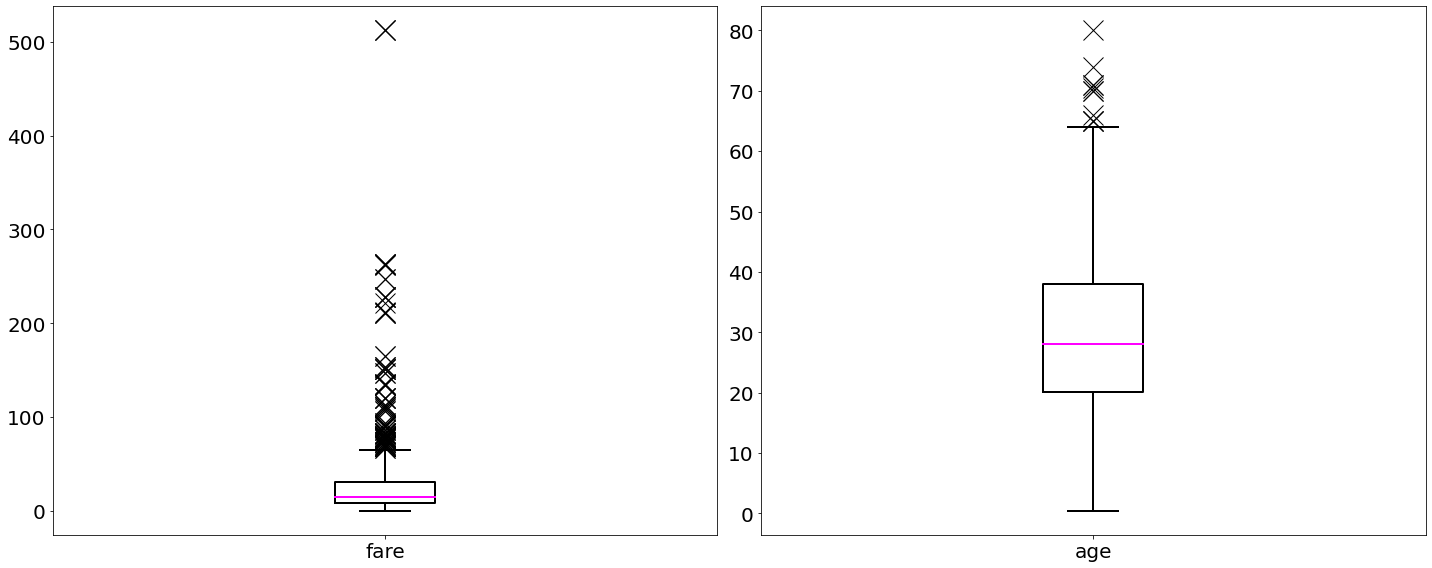

In [16]:
# Boxplot of continuous variables
medianprops = {'color': 'magenta', 'linewidth': 2}
boxprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
whiskerprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
capprops = {'color': 'black', 'linestyle': '-', 'linewidth': 2}
flierprops = {'color': 'black', 'marker': 'x', 'markersize': 20}

_ = df_train_con.plot(kind='box', subplots=True, figsize=(20, 8), layout=(1,2), fontsize = 20,
                      medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops,
                      capprops=capprops, flierprops=flierprops);
_ = plt.tight_layout();
_ = plt.show();


The distributions of the <i>fare</i> and <i>age</i> variables show that fare is skewed heavily to
 the right, with the median skewed to the left of the distribution as expected. The values in the
  final quintile are spread over wide area with quite a few outliers. This distribution is heavy
  tailed, as can be expected of many financial distributions. We observe that there are zero
  values, and there is a large peak in the bin containing zero. We will need to investigate this
  group of travellers as they could be different from the general population. The heavy tail and
  many outliers are also good candidates for further processing.

The <i>age</i> distribution is fairly symmetrical, with a few outliers to the right, but nothing
out of the ordinary. Most of the values are bundled symmetrically around the median of 28, which
is quite a young age for the average traveller. The large spike in ages at this interval is also
concerning and seems out of place. This will need to be further investigated.

We now create a few new variables and analyse the results.

In [17]:
# We will now transform some variables by grouping categories together based on our EDA
# analysis. We also encode categorical variables to numeric values in order to do the ML
# analysis.
# These transformations would not result in data leakage, and can hence be done before we
# split the data into training and testing sets.

# Make a copy of original dataset before imputation - we need the original for further
# analysis.
df_train_trans = df_train.copy()
df_test_trans = df_test.copy()

# Creating Deck field from the first letter of the cabin field (we create a new category for
# missing, which is called M). As this is a categorical variable we will leave the missing
# value field as is.
df_train_trans['deck_orig'] = df_train_trans['cabin'].apply(lambda s: s[0] if pd.notnull
(s) else np.nan)
df_test_trans['deck_orig'] = df_train_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s)
else np.nan)
df_train_trans['deck'] = df_train_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
df_test_trans['deck'] = df_test_trans['cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [18]:
df_train_trans['deck'].value_counts()

M    687
C    59 
B    47 
D    33 
E    32 
A    15 
F    13 
G    4  
T    1  
Name: deck, dtype: int64

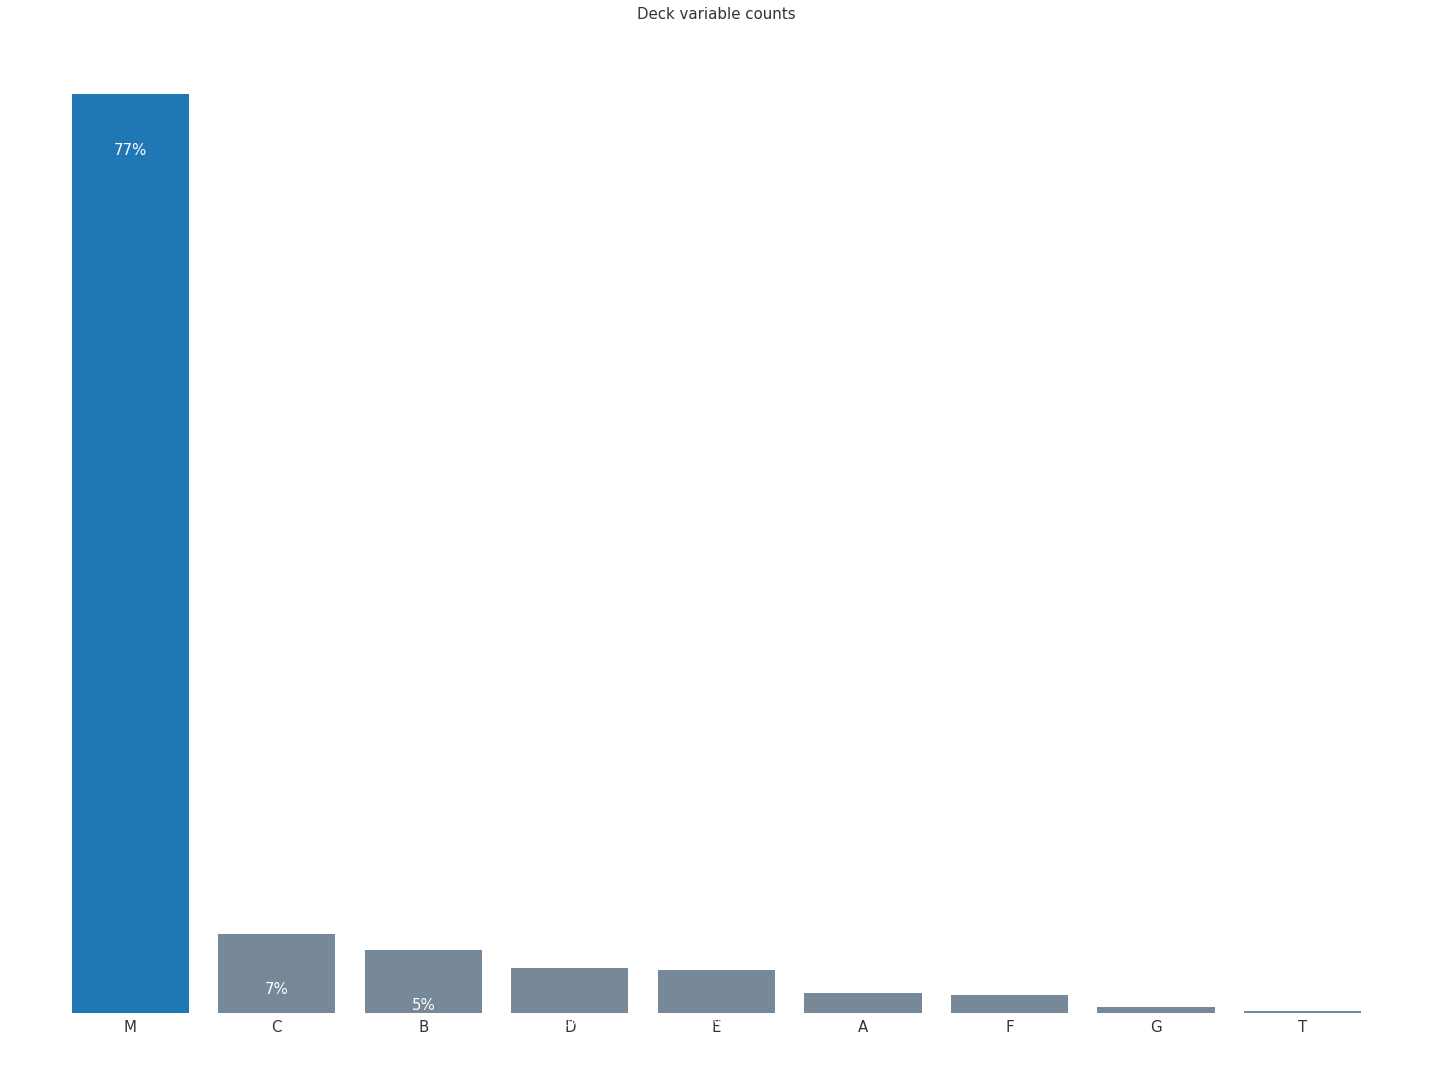

In [19]:
# Bar chart plot of deck.

fig, ax = plt.subplots(1, 1, figsize=(20, 15));
base_color = '#1F77B4'
ax.axes.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)
ax.tick_params('y', labelsize = 20);
ax.tick_params('x', labelsize = 20);
ax.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                    labelbottom=True)
ax.set_frame_on(False)


outcome_counts = df_train_trans['deck'].value_counts(normalize=True)
bars = plt.bar(outcome_counts.index.sort_values(), outcome_counts.values, align='center',
                   linewidth=0,
           color='lightslategrey')
# make one bar, the highest value bar, a contrasting color
bars[0].set_color('#1F77B4')

plt.sca(ax)
_ = plt.xticks(outcome_counts.index.sort_values(), ['M', 'C', 'B', 'D', 'E', 'A', 'F',
                                                    'G', 'T'], fontsize=15, alpha=0.8)
_ = plt.title("Deck variable counts", fontsize=15, pad=30, alpha=0.8)

# direct label each bar with Y axis values
for bar in bars:
    _ = plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
                       str(round((bar.get_height()*100))) + '%', ha='center', color='w',
                       fontsize=15)

plt.tight_layout()

We observe that most of the values for deck ('cabin') are missing.

Seeing as this is a categorical variable creating a "missing category might be
insightful". However, this could be a problem as we don't know whether these values are
missing at random or are missing for some structural reason - which might affect analyses
 if we consider "missing" as a category on its own, which could skew our results.

Next we consider the proportion of survivors within each category.

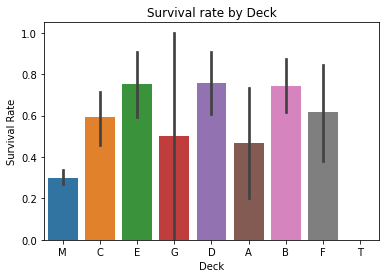

In [20]:
_ = plt.title('Survival rate by Deck')
ax = sns.barplot(x='deck', y='survived', data=df_train_trans).set_ylabel ('Survival Rate')
_ = plt.xlabel('Deck')


There are many values in the smaller deck categories, which we can collapse into other decks
 based on the proportion of survivors in each category.
The missing values do have a significantly lower survival rate and will hence be very useful
 information for the model to use.
There is only one passenger on deck T, and the test set has no values for deck T. The closest
 category is deck 'A' (based on Googling the deck placement on the ship), so we change the
 single occurrence of T to category A.

In [21]:
# There is only one passenger on deck T and the test set has no values for deck T.
# The closest category is deck 'A' (checking on deck arrangements image found via Google), so
# we change all occurrences of T to A.
idx = df_train_trans[df_train_trans['deck'] == 'T'].index
df_train_trans.loc[idx, 'deck'] = 'A'

## Some of the classes have very few values, we group adjacent classes together.
df_train_trans['deck'] = df_train_trans['deck'].replace(['B', 'D', 'E'], 'BDE')
df_train_trans['deck'] = df_train_trans['deck'].replace(['A', 'G'], 'AG')
df_train_trans['deck'] = df_train_trans['deck'].replace(['C', 'F'], 'FG')

df_test_trans['deck'] = df_test_trans['deck'].replace(['B', 'D', 'E'], 'BDE')
df_test_trans['deck'] = df_test_trans['deck'].replace(['A', 'G'], 'AG')
df_test_trans['deck'] = df_test_trans['deck'].replace(['C', 'F'], 'FG')

In [22]:
df_train_trans['deck'].value_counts()
df_train_trans.groupby('deck').survived.mean()

M      687
BDE    112
FG     72 
AG     20 
Name: deck, dtype: int64

deck
AG     0.450000
BDE    0.750000
FG     0.597222
M      0.299854
Name: survived, dtype: float64

In [23]:
#df_test_trans['deck'].value_counts()

##%% md

#The values for the training and test sets look aligned. We don't have survival data for the
#test set (obviously!) so cannot check on this distribution. We can however check form the
#training set.

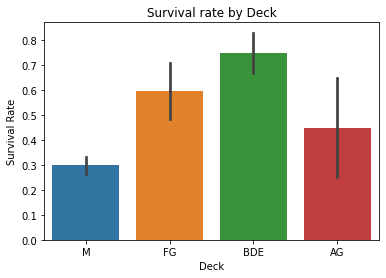

In [24]:
_ = plt.title('Survival rate by Deck')
ax = sns.barplot(x='deck', y='survived', data=df_train_trans).set_ylabel ('Survival Rate')
_ = plt.xlabel('Deck')


### Correlation Analysis

At this point we have learnt the following about the data:

- Ascertained best missing value strategy based on data characteristics:
    - Use KNN imputation for age variable due to strong correlation between missing age
    variables and outcome variable.
    - Use median and mode substitution for remaining missing values, as there are few
    missing values and more complicated methods are hence not warranted.
    - Missing values in cabin have to be assessed given a transformation to the variable
    which we must still decide on.
- Analysis to date (Decision Tree feature strength) and the fact that a gender only model has
 an accuracy of 77% has shown that gender is very strongly correlated with survival rate.
- There are many other data elements correlated with survival rate as well as with each other.
- The majority of variables are categorical.
- The best performing models are those that have been adjusted for overfitting e.g. MLP
models with regularisation parameters. Given the small dataset, many correlated variables
and overpowering effect of a few strongly correlated variables the models created to date
are very prone to overfitting.

The next step in our analysis is to better understand correlation with the response as well
as between feature variables. This analysis will enable to decide how to best engineer
better features that capture the correlation without overfitting. The problem we face is
that the strong correlation between gender and survival is in effect eclipsing all other
correlations and hence reducing their effect. We need to find a way to combine variables to
create a more balanced representation of the correlations.

As we have a binary response variable, Pearson's Correlation will be of no use here as it
assumes a normal distribution and Homoscedasticity which is clearly not the case (I have
noticed that many of the Titanic analyses here on Kaggle use Pearson's correlation heatmap
as implemented by the Pandas <i>corr()</i> function, which has no value or relevance in this
setting).

We will perform correlation analysis as follows:

- Univariate Logistic Regression to measure correlation between categorical response and
continuous feature variables (age, fare)
- Chi-Squared test for association for correlation between categorical response and
categorical feature variables (ticket class, ticket number, # siblings, # parents, fare, cabin
number, port of embarkation).

We start by first performing some transformations on our dataset to get the data into a
format enabling further analysis e.g. encode categorical variables for numeric analysis.

We consider titles extracted from the "name" field first.

In [25]:
# Next we extract the title variable from the name field
df_train_trans = pre_process_title(df_train_trans)
df_test_trans = pre_process_title(df_test_trans)

In [26]:
df_train_trans['title'].value_counts()

df_train_trans['title_orig'] = df_train_trans['title']
df_test_trans['title_orig'] = df_test_trans['title']

Mr              517
Miss            182
Mrs             125
Master          40 
Dr              7  
Rev             6  
Col             2  
Mlle            2  
Major           2  
Jonkheer        1  
Lady            1  
Sir             1  
Capt            1  
Don             1  
Ms              1  
the Countess    1  
Mme             1  
Name: title, dtype: int64

In [27]:
# Next we extract the title variable from the name field
df_train_trans = pre_process_surname(df_train_trans)
df_test_trans = pre_process_surname(df_test_trans)

In [28]:
df_train_trans['surname'].value_counts()

Andersson    9
Sage         7
Goodwin      6
Johnson      6
Panula       6
            ..
Garside      1
Natsch       1
Hirvonen     1
Parrish      1
O'Connor     1
Name: surname, Length: 667, dtype: int64

In [29]:
# Next we extract the title variable from the name field
df_train_trans = pre_process_name(df_train_trans)
df_test_trans = pre_process_name(df_test_trans)

In [30]:
df_train_trans['first_name'].value_counts()


 John                          9
 James                         7
 Mary                          6
 William                       6
 Bertha                        4
                              ..
 Ethel                         1
 Walter                        1
 Viktor Richard                1
 Catherine (Catherine Rizk)    1
 Johan Svensson                1
Name: first_name, Length: 799, dtype: int64

We observe many values with few occurrences. We will group these into the larger four
categories.

In [31]:
df_train_trans['is_married'] = 0
df_train_trans['is_married'].loc[df_train_trans['title'] == 'Mrs'] = 1

df_test_trans['is_married'] = 0
df_test_trans['is_married'].loc[df_test_trans['title'] == 'Mrs'] = 1

In [32]:
df_train_trans['title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
df_test_trans['title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)

df_train_trans['title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev',
                                 'Dr'], 'Mr', inplace=True)
df_test_trans['title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer', 'Rev',
                                'Dr'], 'Mr', inplace=True)


In [33]:
df_train_trans['title'].value_counts()
df_train_trans.groupby('title').survived.mean()

Mr        538
Miss      188
Mrs       125
Master    40 
Name: title, dtype: int64

title
Master    0.575000
Miss      0.707447
Mr        0.161710
Mrs       0.792000
Name: survived, dtype: float64

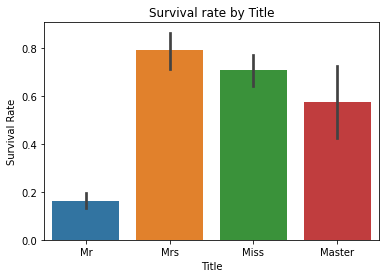

In [34]:
_ = plt.title('Survival rate by Title')
ax = sns.barplot(x='title', y='survived', data=df_train_trans).set_ylabel ('Survival Rate')
_ = plt.xlabel('Title')

Here we get a very nice split with a large proportion of values at a considerably lower
survival rate.

We now encode the gender/ sex value into numeric values.

In [35]:
df_train_trans['sex'].value_counts()
# Transform sex variable - don't need one hot encoding as variable is binary
df_train_trans['sex'] = df_train_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)
# Same transformation for test set - don't need one hot encoding as variable is binary
df_test_trans['sex'] = df_test_trans['sex'].apply(lambda x: 1 if x == 'female' else 0)


male      577
female    314
Name: sex, dtype: int64

In [36]:
df_train_trans['sex'].value_counts()
df_train_trans.groupby('sex').survived.mean()

0    577
1    314
Name: sex, dtype: int64

sex
0    0.188908
1    0.742038
Name: survived, dtype: float64

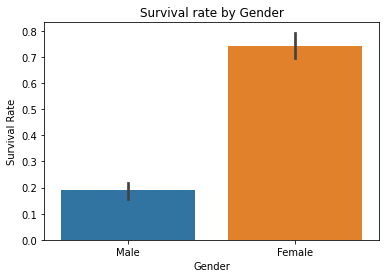

In [37]:
legend_labels = ['Male', 'Female']

_ = plt.title('Survival rate by Gender')
ax = sns.barplot(x='sex', y='survived', data=df_train_trans).set_ylabel ('Survival Rate')
_ = plt.xlabel('Gender')
_ = plt.xticks([0, 1], legend_labels)


We already know that sex is a very strong indicator of survival.

We now impute the missing values in the embarked field and create a family size feature.

In [38]:
# Replace embarked with mode training set - no values missing in test set, so not required
# to further impute. Some leakage takes place here, but only one value so not important -
# TODO: fix this, just as a matter of principle.
train_emb_mode = df_train_trans['embarked'].mode()
df_train_trans['embarked'].fillna(train_emb_mode.iloc[0], inplace=True)

In [39]:
# Create family size feature
df_train_trans['fam_num'] = df_train_trans['sib_sp'] + df_train_trans['parch'] + 1
df_test_trans['fam_num'] = df_test_trans['sib_sp'] + df_test_trans['parch'] + 1

# Create family size groupings
df_train_trans['fam_size'] = pd.cut(df_train_trans.fam_num, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])
df_test_trans['fam_size'] = pd.cut(df_test_trans.fam_num, [0,1,4,7,11], labels=['single',
                           'small', 'large', 'very_large'])

# Now we One Hot Encode Categorical variables. We leave the dimension variables for now, as
# we might generate some cross terms later. We don't One Hot Encode variables with missing
# values e.g. age, as we will impute these during training, and will One Hot Encode at that
# stage.

# Transform embarked and deck variables for training set
categorical_cols = ['embarked', 'deck', 'title', 'p_class', 'fam_size']
df_train_trans['dim_embarked'] = df_train_trans['embarked']
df_train_trans['dim_deck'] = df_train_trans['deck']
df_train_trans['dim_title'] = df_train_trans['title']
df_train_trans['dim_p_class'] = df_train_trans['p_class']
df_train_trans['dim_fam_size'] = df_train_trans['fam_size']
df_train_trans = pd.get_dummies(df_train_trans, columns = categorical_cols, drop_first=True)

# Transform embarked and deck variables for test set
df_test_trans['dim_embarked'] = df_test_trans['embarked']
df_test_trans['dim_deck'] = df_test_trans['deck']
df_test_trans['dim_title'] = df_test_trans['title']
df_test_trans['dim_p_class'] = df_test_trans['p_class']
df_test_trans['dim_fam_size'] = df_test_trans['fam_size']
df_test_trans = pd.get_dummies(df_test_trans, columns = categorical_cols, drop_first=True)


In [40]:
df_train_trans['dim_fam_size'].value_counts()
df_train_trans.groupby('dim_fam_size').survived.mean()


single        537
small         292
large         49 
very_large    13 
Name: dim_fam_size, dtype: int64

dim_fam_size
single        0.303538
small         0.578767
large         0.204082
very_large    0.000000
Name: survived, dtype: float64

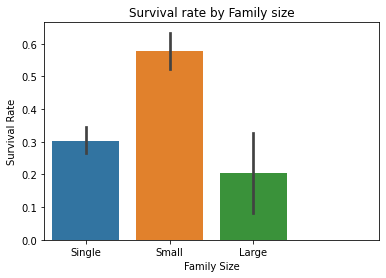

In [41]:
legend_labels = ['Single', 'Small', 'Large']
_ = plt.title('Survival rate by Family size')
ax = sns.barplot(x='dim_fam_size', y='survived', data=df_train_trans).set_ylabel ('Survival '
                                                                                'Rate')
_ = plt.xlabel('Family Size')
_ = plt.xticks([0, 1, 2], legend_labels)


Fairly good split on family size too. Clearly mid-sized families had a higher survival rate.

Next we consider what information we can extract from the "ticket" field. We group tickets
by name and see if the counts yield any information.

In [42]:
df_train_trans['ticket'].value_counts()
df_train_trans.groupby('ticket').survived.mean()

1601        7
CA. 2343    7
347082      7
347088      6
CA 2144     6
           ..
112058      1
29751       1
2926        1
349253      1
349206      1
Name: ticket, Length: 681, dtype: int64

ticket
110152         1.000000
110413         0.666667
110465         0.000000
110564         1.000000
110813         1.000000
                 ...   
W./C. 6608     0.000000
W./C. 6609     0.000000
W.E.P. 5734    0.000000
W/C 14208      0.000000
WE/P 5735      0.500000
Name: survived, Length: 681, dtype: float64

We observe that some ticket numbers have duplicates. We also observe that ticket numbers
typically either survived or some members perished, suggesting that tickets were sold in
batches to families/ groups.
We therefore group ticket numbers by frequency and see if there is any value in this grouping.

In [43]:
# Now we create a variable
df_train_trans['ticket_freq'] = df_train_trans.groupby('ticket')['ticket'].transform('count')
df_test_trans['ticket_freq'] = df_test_trans.groupby('ticket')['ticket'].transform('count')

Let us see what the survival distributions for ticket groups of different sizes are.

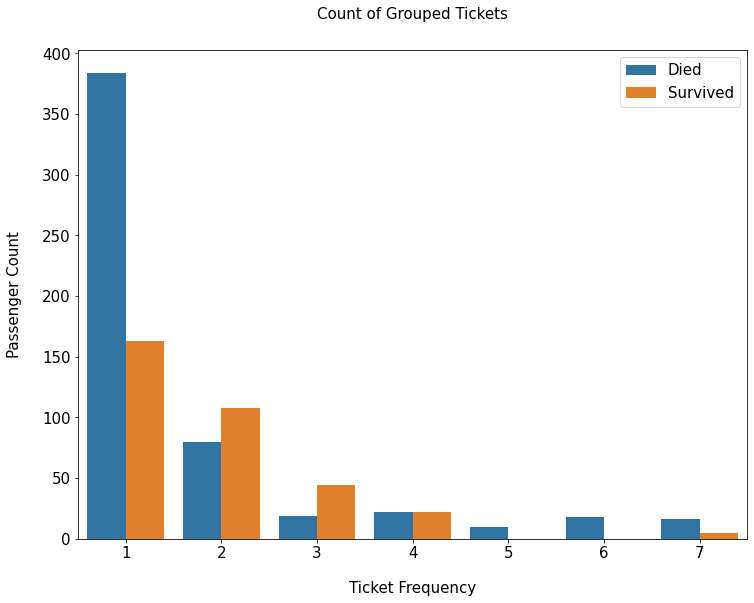

In [44]:
fig, axs = plt.subplots(figsize=(12, 9))
_ = sns.countplot(x='ticket_freq', hue='survived', data=df_train_trans)

_ = plt.xlabel('Ticket Frequency', size=15, labelpad=20)
_ = plt.ylabel('Passenger Count', size=15, labelpad=20)
_ = plt.tick_params(axis='x', labelsize=15)
_ = plt.tick_params(axis='y', labelsize=15)

_ = plt.legend(['Died', 'Survived'], loc='upper right', prop={'size': 15})
_ = plt.title('Count of Grouped Tickets', size=15, y=1.05)

plt.show()
#df_train_trans.head()

##%% md

#We clearly observe that tickets bought in isolation had a much higher death rate. We
#therefore group the variable as a binary indicator variable.
#
#There is not much variation in the lower frequencies, so we group them all together in one
#category.

In [45]:
#df_train_trans['ticket_freq'] = df_train_trans['ticket_freq'].apply(lambda x: 1 if x == 1
#else 0)
## Same transformation for test set - don't need one hot encoding as variable is binary
#df_test_trans['ticket_freq'] = df_test_trans['ticket_freq'].apply(lambda x: 1 if x == 1
#else 0)
#
#df_train_trans['ticket_freq'].value_counts()

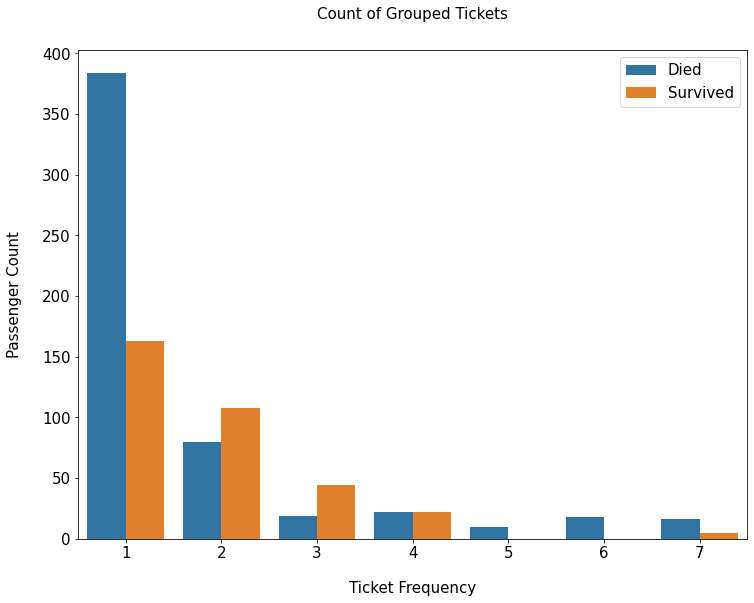

In [46]:
fig, axs = plt.subplots(figsize=(12, 9))
_ = sns.countplot(x='ticket_freq', hue='survived', data=df_train_trans)

_ = plt.xlabel('Ticket Frequency', size=15, labelpad=20)
_ = plt.ylabel('Passenger Count', size=15, labelpad=20)
_ = plt.tick_params(axis='x', labelsize=15)
_ = plt.tick_params(axis='y', labelsize=15)

_ = plt.legend(['Died', 'Survived'], loc='upper right', prop={'size': 15})
_ = plt.title('Count of Grouped Tickets', size=15, y=1.05)

plt.show()

This clearly looks better.


In [47]:
names_all = list(df_train_trans.columns)
print(names_all)

['passenger_id', 'survived', 'name', 'sex', 'age', 'sib_sp', 'parch', 'ticket', 'fare', 'cabin', 'deck_orig', 'title_orig', 'surname', 'first_name', 'is_married', 'fam_num', 'dim_embarked', 'dim_deck', 'dim_title', 'dim_p_class', 'dim_fam_size', 'embarked_Q', 'embarked_S', 'deck_BDE', 'deck_FG', 'deck_M', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_2', 'p_class_3', 'fam_size_small', 'fam_size_large', 'fam_size_very_large', 'ticket_freq']


In [48]:
# Update dataframe fieldname values
drop_cols = ['name', 'sib_sp', 'parch', 'ticket', 'passenger_id', 'dim_embarked',
             'cabin', 'fam_num',
             'dim_deck', 'title_orig', 'dim_title', 'dim_p_class', 'dim_fam_size',
             'deck_orig', 'surname', 'first_name']

# These stay static
names_con = ('fare', 'age')
names_con_plot = ('survived', 'fare', 'age')

# These change depending on prior analyses
names_cat = names_all.copy()
for x in drop_cols:
    names_cat.remove(x)
for x in ['survived', 'age', 'fare']:
    names_cat.remove(x)

print("names_cat: {}".format(names_cat))

names_cat_plot = names_all.copy()
for x in drop_cols:
    names_cat_plot.remove(x)
for x in ['age', 'fare']:
    names_cat_plot.remove(x)

for x in drop_cols:
    names_all.remove(x)
for x in ['survived']:
    names_all.remove(x)

names_cat: ['sex', 'is_married', 'embarked_Q', 'embarked_S', 'deck_BDE', 'deck_FG', 'deck_M', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_2', 'p_class_3', 'fam_size_small', 'fam_size_large', 'fam_size_very_large', 'ticket_freq']


Next we run a uni-variate Logistic regression for each categorical variable on its own and
record the accuracy scores obtained.

Features: 16/16

Best accuracy score: 0.79
Best subset (indices): (0,)
Best subset (corresponding names): ('sex',)


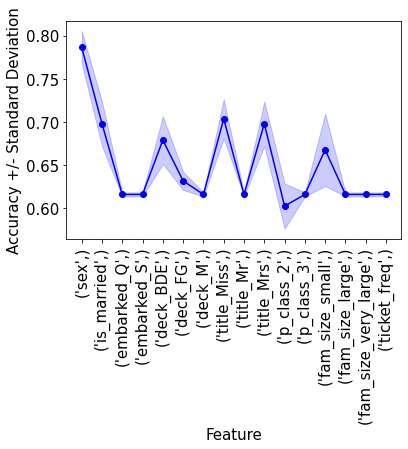

feature_idx                                                                                             cv_scores avg_score           feature_names  ci_bound   std_dev   std_err
0   (0,)        [0.8044692737430168, 0.8033707865168539, 0.7865168539325843, 0.7528089887640449, 0.7865168539325843]  0.786737  (sex,)                  0.023993  0.018667  0.009334
7   (7,)        [0.7262569832402235, 0.7191011235955056, 0.6853932584269663, 0.7191011235955056, 0.6685393258426966]  0.703678  (title_Miss,)           0.029052  0.022604  0.011302
1   (1,)        [0.6927374301675978, 0.702247191011236, 0.7191011235955056, 0.651685393258427, 0.7247191011235955]    0.698098  (is_married,)           0.033268  0.025884  0.012942
9   (9,)        [0.6927374301675978, 0.702247191011236, 0.7191011235955056, 0.651685393258427, 0.7247191011235955]    0.698098  (title_Mrs,)            0.033268  0.025884  0.012942
4   (4,)        [0.6312849162011173, 0.6741573033707865, 0.6797752808988764, 0.6966292134831461, 0.7134831460674157]  0.679066  (deck_BDE,)             0.035436  0.02757   0.013785
12  (12,)       [0.5977653631284916, 0.6460674157303371, 0.6797752808988764, 0.702247191011236, 0.7134831460674157]   0.667868  (fam_size_small,)       0.053903  0.041938  0.020969
5   (5,)        [0.6368715083798883, 0.6404494382022472, 0.6123595505617978, 0.6292134831460674, 0.6404494382022472]  0.631869  (deck_FG,)              0.013602  0.010582  0.005291
2   (2,)        [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (embarked_Q,)           0.002988  0.002325  0.001162
3   (3,)        [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (embarked_S,)           0.002988  0.002325  0.001162
6   (6,)        [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (deck_M,)               0.002988  0.002325  0.001162
8   (8,)        [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (title_Mr,)             0.002988  0.002325  0.001162
11  (11,)       [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (p_class_3,)            0.002988  0.002325  0.001162
13  (13,)       [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (fam_size_large,)       0.002988  0.002325  0.001162
14  (14,)       [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (fam_size_very_large,)  0.002988  0.002325  0.001162
15  (15,)       [0.6145251396648045, 0.6179775280898876, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]  0.616163  (ticket_freq,)          0.002988  0.002325  0.001162
10  (10,)       [0.6145251396648045, 0.550561797752809, 0.6179775280898876, 0.6179775280898876, 0.6123595505617978]   0.60268   (p_class_2,)            0.033607  0.026147  0.013074

In [49]:
X_train = df_train_trans.loc[:, names_cat]
y_train = df_train_trans.loc[:, "survived"]

logval = LogisticRegression(fit_intercept = False)

efs1 = EFS(logval,
           min_features=1,
           max_features=1,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(X_train, y_train, custom_feature_names=names_cat)

print('Best accuracy score: %.2f' % efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

#efs1 = efs1.fit(X, y, custom_feature_names=feature_names)

df_efs = pd.DataFrame.from_dict(efs1.get_metric_dict()).T
df_efs.sort_values('avg_score', inplace=True, ascending=False)

metric_dict = efs1.get_metric_dict()

fig = plt.figure()
k_feat = sorted(metric_dict.keys())
avg = [metric_dict[k]['avg_score'] for k in k_feat]

upper, lower = [], []
for k in k_feat:
    upper.append(metric_dict[k]['avg_score'] +
                 metric_dict[k]['std_dev'])
    lower.append(metric_dict[k]['avg_score'] -
                 metric_dict[k]['std_dev'])

plt.fill_between(k_feat,
                 upper,
                 lower,
                 alpha=0.2,
                 color='blue',
                 lw=1)

_ = plt.plot(k_feat, avg, color='blue', marker='o');
_ = plt.ylabel('Accuracy +/- Standard Deviation', size = 15)
_ = plt.xlabel('Feature', size = 15)
feature_min = len(metric_dict[k_feat[0]]['feature_idx'])
feature_max = len(metric_dict[k_feat[-1]]['feature_idx'])
_ = plt.xticks(k_feat,
           [str(metric_dict[k]['feature_names']) for k in k_feat],
           rotation=90, size = 15)
_ = plt.yticks(size = 15)
plt.show();

df_efs

#eda_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

#sns.pairplot(df_train, vars=names_all, hue='survived', plot_kws = {'alpha': 0.6, 's': 40,
# 'edgecolor': 'k'}, palette=sns.color_palette("hls", 2), size=8)



We already knew that gender was going to be the winner here. Again it is useful to reflect
on just how strongly this variable is correlated with the outcome. Gender by itself
obtaining an accuracy of 79% is noteworthy.

Our newly generated title variable does not seem to be adding much to the party here, it
comes in second but is likely to contain the same information as gender. We can probably
drop this variable, or alternatively attempt to improve gender with information contained in
 the title variable.

All the other variables show strong correlation with the outcome variable. We will have
 to carefully consider variable interactions to find combinations of some variables
 that avoid multi-collinearity and hence maximises the signal in the data.

Next we will consider correlation between the continuous variables and the response. We have
two continuous variables, <i>age</i> and <i>fare</i>.

Feature:                 fare	Score:	14.21324
Feature:                  age	Score:	1.13380


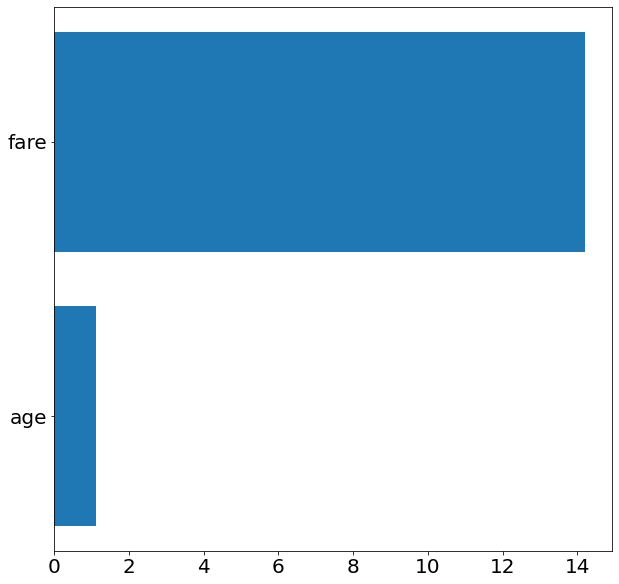

In [50]:
X_train = df_train_trans.loc[:, names_con]
y_train = df_train_trans.loc[:, "survived"]

# Replace missing values for continuous variables - else we cannot compute correlation
# statistics.

# Replace fare in test set with median from train set - to prevent data leakage.
median_fare = X_train['fare'].median()
X_train['fare'].fillna(median_fare, inplace=True)

# Replace missing values for training set
#print("Number of null values in age column: {}".format(X_train['age'].isnull().sum()))

# Define imputer
imputer = KNNImputer()
# fit on the dataset
_ = imputer.fit(X_train)
# transform the dataset
X_train_array = imputer.transform(X_train)
X_train = pd.DataFrame(X_train_array, columns=names_con)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_train).flatten()))

# Feature extraction set to retain all - we want to see scores for all variables.
test = SelectKBest(score_func=f_classif, k='all')
fit_kbest = test.fit(X_train, y_train)
features_kbest = np.array(names_con)
plot_feature_importance(fit = fit_kbest, features = features_kbest)

It is clear from the output of the Chi-Squared test that fare has a higher correlation with
survival rate than age.

In order to see how feature importances amongst all the variables stack up (categorical and
continuous) we will now analyse correlation and feature importance by considering the output
 of a Random Forest model which deals with categorical and continuous variables in the same
 manner.


In [51]:
X_train = df_train_trans.loc[:, names_all]
y_train = df_train_trans.loc[:, "survived"]

# Replace fare in test set with median from train set - to prevent data leakage.
median_fare = X_train['fare'].median()
X_train['fare'].fillna(median_fare, inplace=True)

# Replace missing values for training set
#print("Number of null values in age column: {}".format(X_train['age'].isnull().sum()))

# Define imputer
imputer = KNNImputer()
# fit on the dataset
_ = imputer.fit(X_train)
# transform the dataset
X_train_array = imputer.transform(X_train)
X_train = pd.DataFrame(X_train_array, columns=names_all)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_train).flatten()))

rand_forest = RandomForestClassifier(max_features=0.25, n_estimators=1000, criterion= 'gini',
                                     random_state=0)
rand_forest.fit(X_train, y_train)

RandomForestClassifier(max_features=0.25, n_estimators=1000, random_state=0)

Feature:                  age	Score:	0.23654
Feature:                 fare	Score:	0.19675
Feature:             title_Mr	Score:	0.13351
Feature:                  sex	Score:	0.10006
Feature:          ticket_freq	Score:	0.05832
Feature:            p_class_3	Score:	0.04841
Feature:           title_Miss	Score:	0.03555
Feature:               deck_M	Score:	0.03020
Feature:       fam_size_small	Score:	0.02600
Feature:           is_married	Score:	0.02378
Feature:            title_Mrs	Score:	0.02185
Feature:           embarked_S	Score:	0.02072
Feature:             deck_BDE	Score:	0.01994
Feature:       fam_size_large	Score:	0.01507
Feature:            p_class_2	Score:	0.01387
Feature:           embarked_Q	Score:	0.00812
Feature:              deck_FG	Score:	0.00654
Feature:  fam_size_very_large	Score:	0.00478


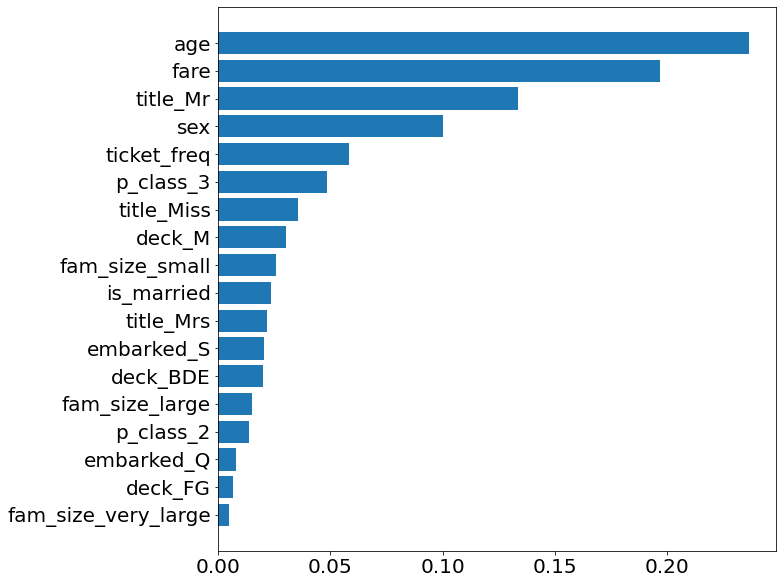

In [52]:
importances = np.array(rand_forest.feature_importances_)
feature_list = np.array(X_train.columns)
plot_feature_importance_dec(fit = importances, features = feature_list)

This is really interesting. Even though Chi-square ranks fare higher than age in terms of
importance, the Random Forest ranks age as the most important feature in this analysis. From
 this we can deduce that age has significant interactions with other variables that result
 survival being classified more accurately.

We can use this information to engineer more meaningful feature variables.

Next we will analyse the results of the actual Decision Tree.

In [53]:
estimator = rand_forest.estimators_[1]

# Show the first few levels of the tree
_ = export_graphviz(estimator, out_file='tree.dot',
                feature_names = X_train.columns,
                max_depth = 6,
                class_names = ['Died', 'Survived'],
                rounded = True, proportion = True,
                label='root',
                precision = 2, filled = True);

In [54]:
_ = call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
#_ = call(['dot', '-Tsvg', 'tree.dot', '-o tree.svg', 'tree.svg', '-Gdpi=600'])
Image(filename = 'tree.png')
#plt.show()


From the Decision Tree output we can observe many interesting variable interactions
(combinations of branches that result in clear distinctions of survival or death) such as the
following:

- gender and age (first 3 levels of splits are mainly on gender and age)
- gender and deck
- fare and p_class
- fare and age
- fare and embarked

Further investigation is warranted as there are many meaningful interactions. Let us look at a
few more graphs illustrating these interactions.

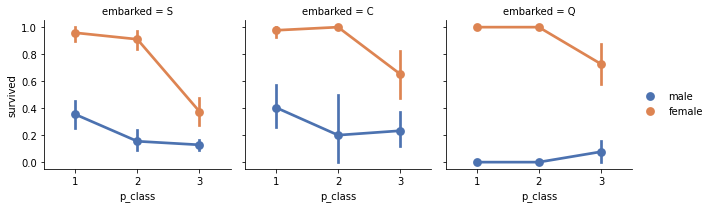

In [55]:
chivalry = sns.FacetGrid(df_train, col = 'embarked')
_ = chivalry.map(sns.pointplot, 'p_class', 'survived', 'sex', ci=95.0, palette = 'deep',
                 order = [1,2,3], hue_order = ['male','female'])
_ = chivalry.add_legend()


<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>Missing
Values</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Identify most
appropriate imputation strategy</center></p>

In [56]:
# We use will use all of the variables from here onwards.
df_train = df_train.loc[:, ['survived', 'p_class', 'name', 'sex', 'age', 'sib_sp', 'parch',
                            'ticket', 'fare', 'cabin', 'embarked']]

In [57]:
df_test = df_test.loc[:, ['p_class', 'name', 'sex', 'age', 'sib_sp', 'parch', 'ticket',
                          'fare', 'cabin', 'embarked']]

We previously noted that there are missing values in the following fields: age, fare and
embarked.

We quantify the exact number of missing values in the training set:

In [58]:
# Check for null values
missing_values_train = df_train.isnull().sum()
missing_values_train = missing_values_train.to_frame(name='num_missing')
missing_values_train['perc_missing'] = (missing_values_train['num_missing']/df_train.shape[0])*100
for index, row in missing_values_train.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "age" the number of missing values are: 177 (20%)
For "cabin" the number of missing values are: 687 (77%)
For "embarked" the number of missing values are: 2 (0%)


Consider a sample of missing values from the training set:


In [59]:
df_train[df_train.isnull().any(axis=1)]


survived  p_class                                      name     sex   age  sib_sp  parch            ticket     fare cabin embarked
0    0         3        Braund, Mr. Owen Harris                   male    22.0  1       0      A/5 21171         7.2500   NaN   S      
2    1         3        Heikkinen, Miss. Laina                    female  26.0  0       0      STON/O2. 3101282  7.9250   NaN   S      
4    0         3        Allen, Mr. William Henry                  male    35.0  0       0      373450            8.0500   NaN   S      
5    0         3        Moran, Mr. James                          male   NaN    0       0      330877            8.4583   NaN   Q      
7    0         3        Palsson, Master. Gosta Leonard            male    2.0   3       1      349909            21.0750  NaN   S      
..  ..        ..                                   ...             ...    ...  ..      ..         ...                ...  ...  ..      
884  0         3        Sutehall, Mr. Henry Jr                    male    25.0  0       0      SOTON/OQ 392076   7.0500   NaN   S      
885  0         3        Rice, Mrs. William (Margaret Norton)      female  39.0  0       5      382652            29.1250  NaN   Q      
886  0         2        Montvila, Rev. Juozas                     male    27.0  0       0      211536            13.0000  NaN   S      
888  0         3        Johnston, Miss. Catherine Helen "Carrie"  female NaN    1       2      W./C. 6607        23.4500  NaN   S      
890  0         3        Dooley, Mr. Patrick                       male    32.0  0       0      370376            7.7500   NaN   Q      

[708 rows x 11 columns]

Quantify the exact number of missing values in the test set:

In [60]:
# Check for null values
missing_values_test = df_test.isnull().sum()
missing_values_test = missing_values_test.to_frame(name='num_missing')
missing_values_test['perc_missing'] = (missing_values_test['num_missing']/df_test.shape[0])*100
for index, row in missing_values_test.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "age" the number of missing values are: 86 (21%)
For "fare" the number of missing values are: 1 (0%)
For "cabin" the number of missing values are: 327 (78%)


Consider a sample of missing values from the test set:

In [61]:
# Actual null values
df_test[df_test.isnull().any(axis=1)]

p_class                                          name     sex   age  sib_sp  parch              ticket     fare cabin embarked
0    3        Kelly, Mr. James                              male    34.5  0       0      330911              7.8292   NaN   Q      
1    3        Wilkes, Mrs. James (Ellen Needs)              female  47.0  1       0      363272              7.0000   NaN   S      
2    2        Myles, Mr. Thomas Francis                     male    62.0  0       0      240276              9.6875   NaN   Q      
3    3        Wirz, Mr. Albert                              male    27.0  0       0      315154              8.6625   NaN   S      
4    3        Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0  1       1      3101298             12.2875  NaN   S      
..  ..                                                 ...     ...   ... ..      ..          ...                 ...  ...  ..      
412  3        Henriksson, Miss. Jenny Lovisa                female  28.0  0       0      347086              7.7750   NaN   S      
413  3        Spector, Mr. Woolf                            male   NaN    0       0      A.5. 3236           8.0500   NaN   S      
415  3        Saether, Mr. Simon Sivertsen                  male    38.5  0       0      SOTON/O.Q. 3101262  7.2500   NaN   S      
416  3        Ware, Mr. Frederick                           male   NaN    0       0      359309              8.0500   NaN   S      
417  3        Peter, Master. Michael J                      male   NaN    1       1      2668                22.3583  NaN   C      

[331 rows x 10 columns]

We observed 177 (20%) null values for <i>age</i>, 687 (77%) for <i>cabin</i> and 2 (0%) for
<i>embarked</i> for <i>training data</i> and 86 (21%) null values for <i>age</i>, 327 (78%)
 for <i>cabin</i> and 1 (0%) for <i>fare</i> for <i>testing data</i>.

The visualised missing values look as follows for the data:

Null values in training data :
survived    0  
p_class     0  
name        0  
sex         0  
age         177
sib_sp      0  
parch       0  
ticket      0  
fare        0  
cabin       687
embarked    2  
dtype: int64
Null values in testing data :
p_class     0  
name        0  
sex         0  
age         86 
sib_sp      0  
parch       0  
ticket      0  
fare        1  
cabin       327
embarked    0  
dtype: int64


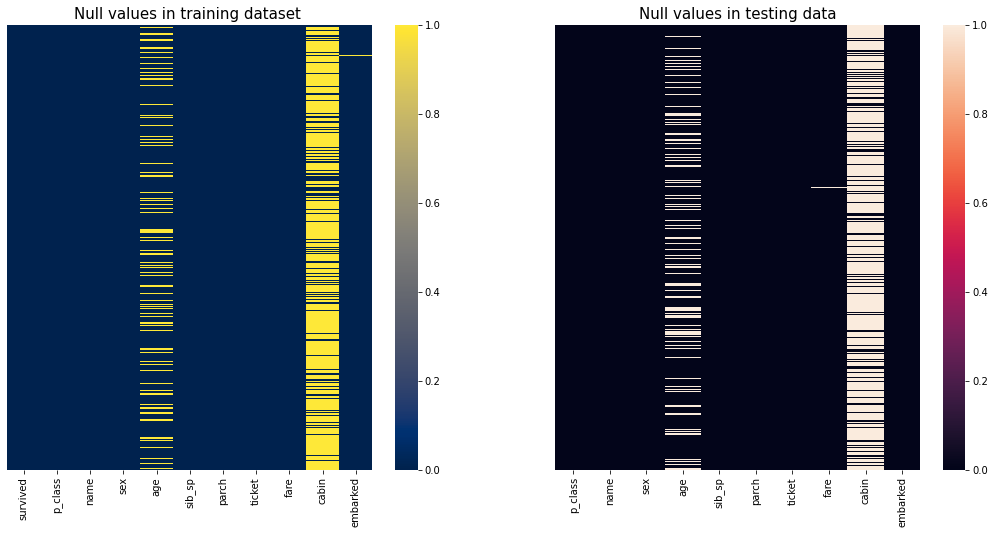

In [62]:
cprint('Null values in training data :', 'green')
print(df_train.isnull().sum())
cprint('Null values in testing data :', 'green')
print(df_test.isnull().sum())

plt.figure(figsize=(18,18))

plt.subplot(221)
sns.heatmap(df_train.isnull(), yticklabels = False, cmap='cividis')
plt.title('Null values in training dataset ',size=15);
plt.subplot(222)
sns.heatmap(df_test.isnull(), yticklabels = False)
plt.title('Null values in testing data',size=15);


From the evidence we have thus far we can conclude the following:

- The age (continuous) and cabin (categorical) variables have a significant number of missing
values.
- The cabin variable has in excess of 70% missing entries, which is substantive.
- The missing values for these variables seem to be randomly scattered throughout the data.
Without more information it is difficult to tell whether these variables are missing at
random or for some systemic reason. We will do some more analysis to try and ascertain this.

It is important for us to decide on a missing value replacement strategy for age and cabin.
The other variables have an insignficant number of missing values and hence simple
imputation will be performed.

We will start by analysing the distributions for age first to get a feel for the data.

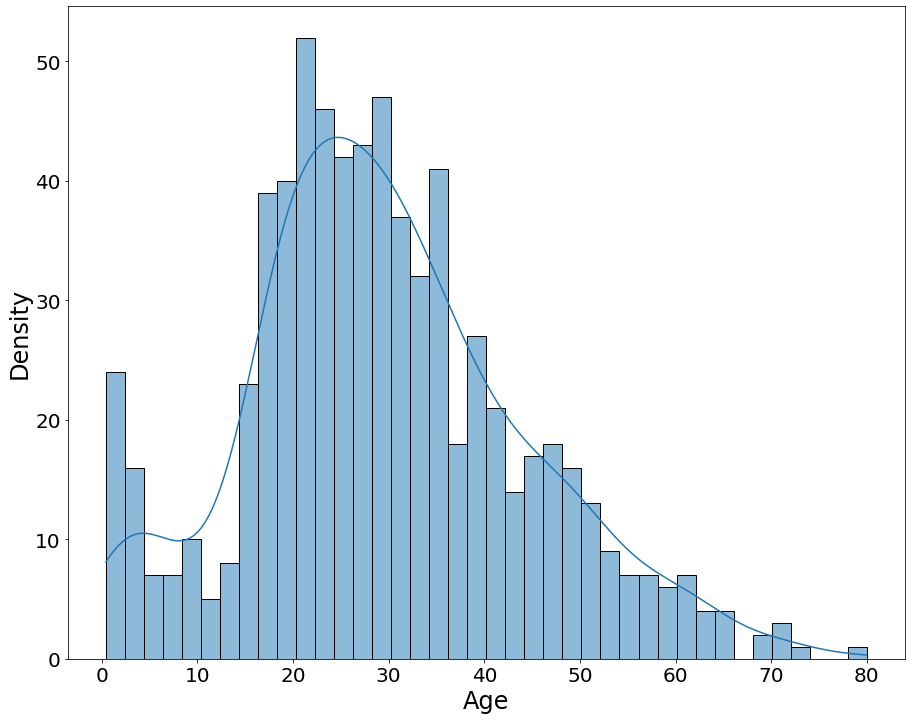

In [63]:
# Continuous density plot
fig_missing, axes = plt.subplots(1, 1, figsize=(15, 12))

# Plot frequency plot/ histogram
_ = sns.histplot(x="age", kde=True, data=df_train, ax=axes, bins=40);
_ = axes.set(xlabel="Age", ylabel='Density');
axes.xaxis.label.set_size(24)
axes.yaxis.label.set_size(24)
axes.tick_params('y', labelsize = 20);
axes.tick_params('x', labelsize = 20);

## Continuous density plot
#fig_missing, axes = plt.subplots(1, 1, figsize=(15, 12))
#
## Plot frequency plot/ histogram
#_ = sns.histplot(x="age", kde=True, data=df_test, ax=axes, bins=40);
#_ = axes.set(xlabel="Age", ylabel='Density');
#axes.xaxis.label.set_size(24)
#axes.yaxis.label.set_size(24)
#axes.tick_params('y', labelsize = 20);
#axes.tick_params('x', labelsize = 20);
#

In [64]:
print("Age summary statistics (training set):\n")
print(df_train['age'].describe())
print("\nAge summary statistics (testing set):\n")
print(df_test['age'].describe())

Age summary statistics (training set):

count    714.000000
mean     29.699118 
std      14.526497 
min      0.420000  
25%      20.125000 
50%      28.000000 
75%      38.000000 
max      80.000000 
Name: age, dtype: float64

Age summary statistics (testing set):

count    332.000000
mean     30.272590 
std      14.181209 
min      0.170000  
25%      21.000000 
50%      27.000000 
75%      39.000000 
max      76.000000 
Name: age, dtype: float64


The age variable is similarly distributed for both the training and test set i.e. there is a
 skew to the right with a slight bump on the left for lower ages. Maximum age was 80 and
 minimum age was around 2 months.

High level analysis does not seem to show any specific problematic values within either set
of data.

Next we consider whether there is correlation between missing age values and the outcome
variable i.e. survival. There are a significant number of missing age values, and if the
missing values are correlated with the outcome we should consider a more complex mechanism
for missing value substitution such as multiple imputation.

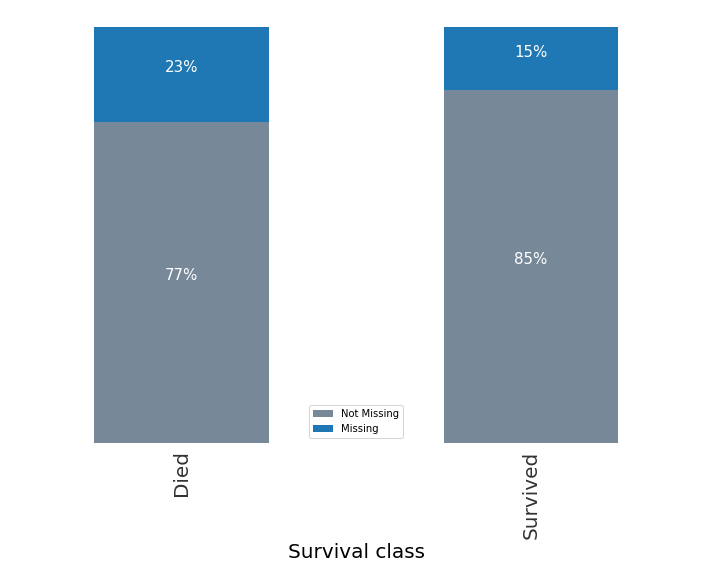

In [65]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), squeeze=False)
legend_labels = ['Died', 'Survived']
colors = ["lightslategrey", "#1F77B4"]

df_train['age_missing'] = df_train.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)

age_missing_stacked = df_train.loc[:, ["survived", "age_missing"]]
age_missing_stacked.index.name = "passenger_num"
ctable_survival_missing = pd.crosstab(age_missing_stacked.survived, age_missing_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Survived"])
ctable_survival_missing_perc = pd.crosstab(age_missing_stacked.survived, age_missing_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Survived"],
                                           normalize="index")

#ctable_survival_missing.columns = ["Not Missing", "Missing"]
#ctable_survival_missing["Survived"] = ["Died", "Survived"]
#ctable_survival_missing = ctable_survival_missing.set_index("Survived")
#print(ctable_survival_missing)

ctable_survival_missing_perc.columns = ["Not Missing", "Missing"]
ctable_survival_missing_perc["Survived"] = ["Died", "Survived"]
ctable_survival_missing_perc = ctable_survival_missing_perc.set_index("Survived")

axs = plt.gca()
axs.set_frame_on(False)
#age_miss_stack = ctable_survival_missing.plot.bar(stacked=True, ax=axs, color=colors)
age_miss_stack = ctable_survival_missing_perc.plot.bar(stacked=True, ax=axs, color=colors)
_ = plt.xlabel('Survival class', fontsize=20)
#_ = plt.ylabel('Percentage Missing', fontsize=20)
_ = plt.xticks([0, 1], legend_labels, fontsize=15, alpha=0.8)
_ = plt.xticks(fontsize=20)
#_ = plt.yticks(fontsize=20)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Bit of a hack - TODO, clean up here.
#totals = ctable_survival_missing.iloc[:,0] + ctable_survival_missing_.iloc[:,1]
totals = ctable_survival_missing_perc.iloc[:,0] + ctable_survival_missing_perc.iloc[:,1]
#tot_arr = totals.to_numpy()

for i, rec in enumerate(age_miss_stack.patches):
    height = rec.get_height()
    j = i//2
    _ = age_miss_stack.text(rec.get_x() + rec.get_width() / 2,
              rec.get_y() + height / 2,
              "{:.0f}%".format(height/totals[j]*100),
              ha='center',
              va='bottom',
              color="w",
              fontsize = 15)

plt.tight_layout()

We observe that there is a larger proportion of missing values in the group of individuals
that died compared to the survival group, which suggests correlation between the
missing values and outcome variable (survival).

We will now perform a Chi-Squared test for independence to determine whether there is
correlation between missing age values and survival.

In [66]:
survived = df_train.loc[df_train["survived"] == 1,:]
died = df_train.loc[df_train["survived"] == 0,:]

survived_cont = survived["age_missing"].value_counts(normalize=False)
died_cont = died["age_missing"].value_counts(normalize=False)

_ = survived_cont.rename("survived", inplace=True)
_ = died_cont.rename("died", inplace=True)

#cont_table = pd.concat([survived_cont, died_cont], axis=1)

print(ctable_survival_missing)

#stat, p, dof, expected = chi2_contingency(cont_table)
stat, p, dof, expected = chi2_contingency(ctable_survival_missing)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')



Missing Age    0    1
Survived             
0            424  125
1            290  52 
dof=1
[[439.939 109.061]
 [274.061  67.939]]
probability=0.950, critical=3.841, stat=7.106
Dependent (reject H0)
significance=0.050, p=0.008
Dependent (reject H0)


We can see from the results of the Chi-Squared test that the missing values in the age data
is strongly correlated with the outcome of survival (p=0.008).

This suggests strongly that we will have to take care when imputing values for age i.e.
inaccurate imputation might lead to an adverse effect on model accuracy. It is therefore
important to ensure that missing values are imputed as accurately as possible, especially
taking other variables into account i.e. missing values in particular groupings of values
might have strong correlation with the response. An advance technique such as multiple
imputation (MICE) or another predictive model such as K-Nearest Neighbour (KNN) is required
to ensure age is imputed correctly for these sub-groupings of values.

This also indicates that we could use the missing values later during feature engineering
and assess possibility of improved model performance based on additional variables built
using the missing value information.

Next we will look at the distribution of missing age values in relation to the other
variables to gain more insight into the missing values. We start with the continuous variables
and therefore we consider the fare variable first. We start with some simple distribution
plots (histograms).

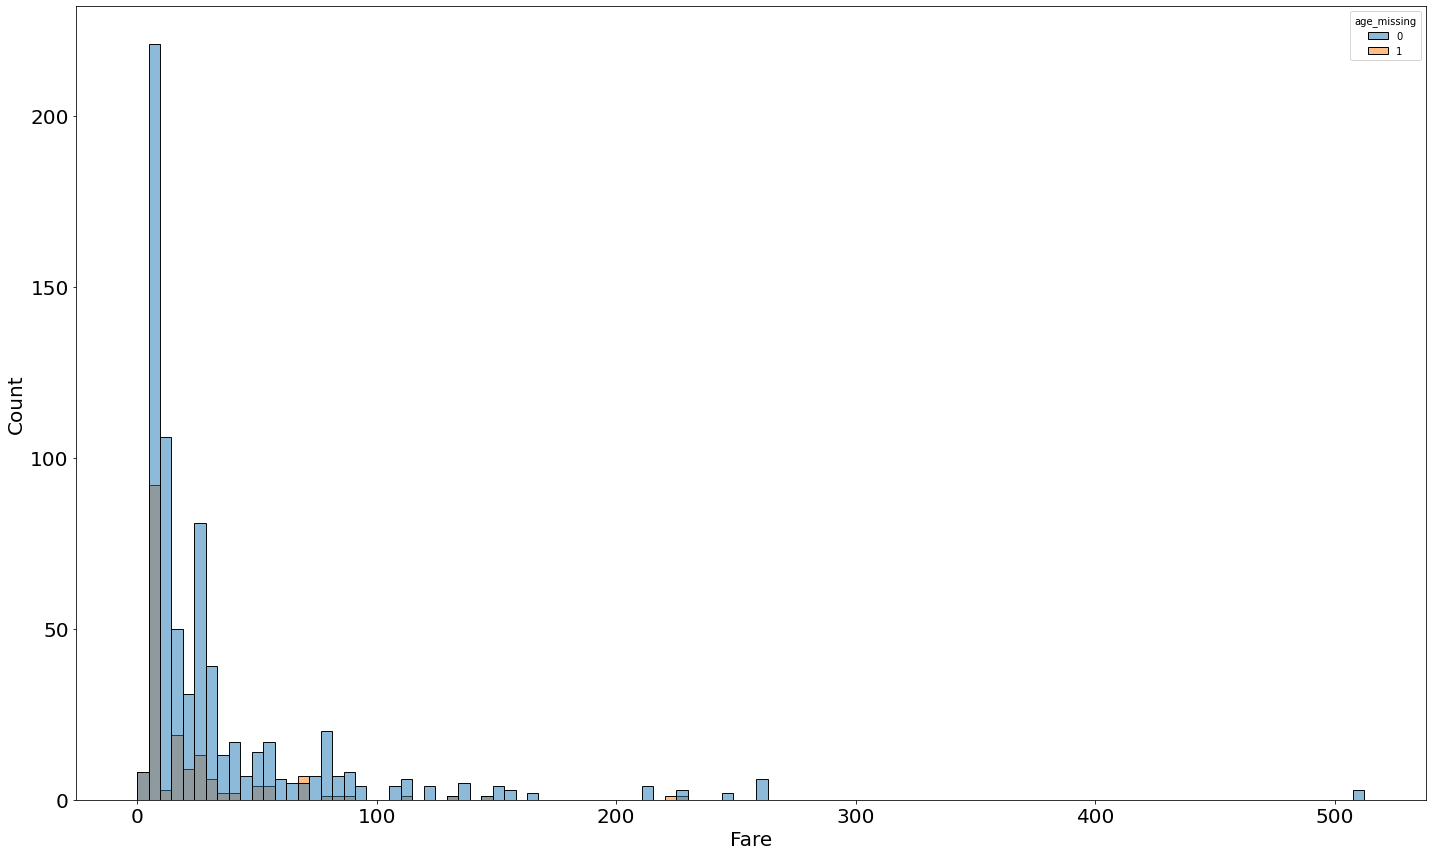

In [67]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), squeeze=False)

ax1 = sns.histplot(data = df_train, x = "fare", hue = "age_missing", ax=axes[0][0],
                   legend=True)

_ = plt.xlabel('Fare', fontsize=20)
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
#ax1.legend.set_title("Missing Age")

plt.tight_layout()

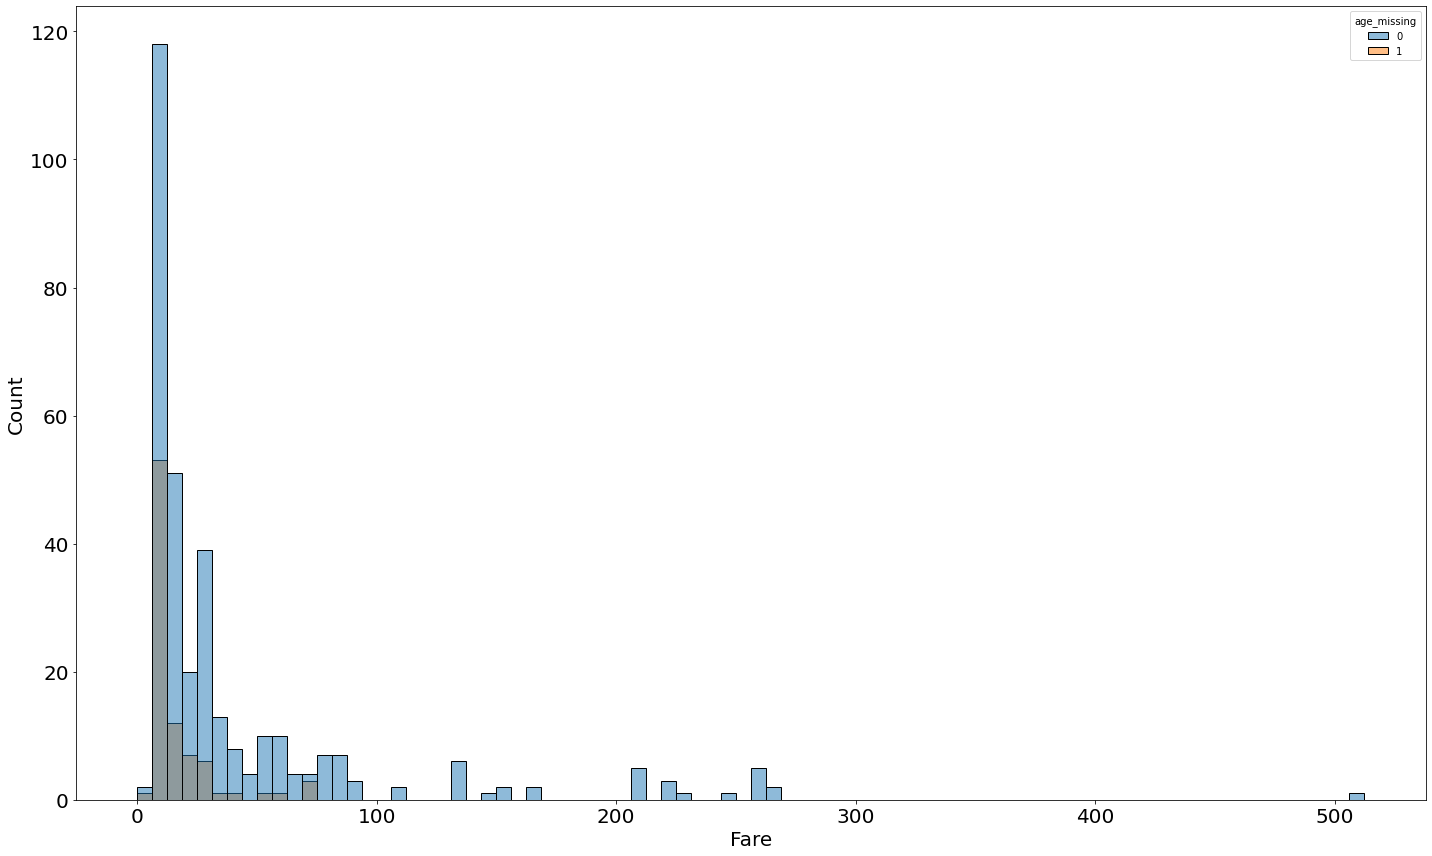

In [68]:
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), squeeze=False)

df_test['age_missing'] = df_test.apply(lambda row: 1 if np.isnan(row['age']) else 0, axis=1)
_ = sns.histplot(data = df_test, x = "fare", hue = "age_missing", ax=axes[0][0])

_ = plt.xlabel('Fare', fontsize=20)
_ = plt.ylabel('Count', fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)
plt.tight_layout()

It is evident by inspection that the number of missing age values is higher for lower fares
in both the testing and training datasets. We now look at the same data plotted on
histograms to further explore the relationship between missing values and fare. We now
however add another dimension in that we also consider survival rate as an additional factor.

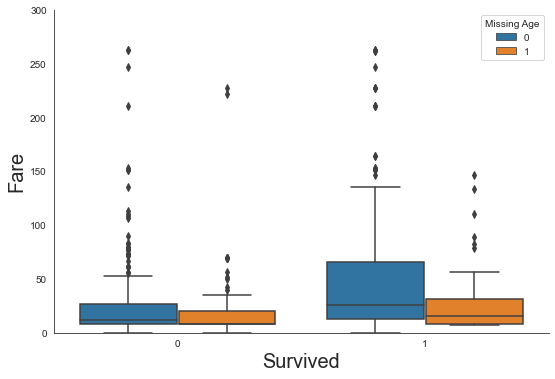

In [69]:
sns.set_style("white")
ax = sns.catplot(x="survived", y="fare", hue="age_missing", kind="box", data=df_train,
                 height = 5, aspect = 1.5, legend=False)
_ = ax.set(ylim=(0, 300))
_ = plt.xlabel('Survived', fontsize=20)
_ = plt.ylabel('Fare', fontsize=20)
_ = plt.legend(title='Missing Age')
plt.show()

It must be noted that we adapted the y-axis to cut off outlier values above 300. There were
a few values clustered at approximately 500.

The boxplots shows the same pattern we observed when considering the histograms i.e. the
distribution of fare values is different for the missing and non-missing (age) groups. For the
missing age group values are concentrated around smaller fare values.

Additionally and interestingly this plot also shows that when taking survival into account
the effect is enlarged i.e. for those who survived and paid higher fares age is typically
not missing.

At this point we could do a correlation test between missing values and fare by means of
using a logistic regression. We however leave as a later exercise as we have enough evidence
to include fare in any imputation method used to impute missing values.

Next we look at the categorical variables. We start with passenger class travelled first.

Missing Age        0    1
Passenger Class          
1                186  30 
2                173  11 
3                355  136


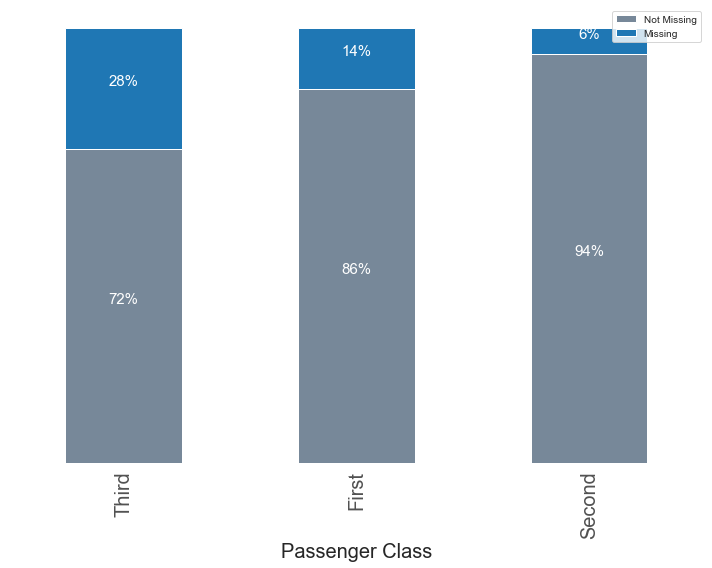

In [70]:
sns.set_style("white")
fig_age, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), squeeze=False)
legend_labels = ['Third', 'First', 'Second']
colors = ["lightslategrey", "#1F77B4"]

age_pclass_stacked = df_train.loc[:, ["p_class", "age_missing"]]
age_pclass_stacked.index.name = "passenger_num"
ctable_pclass_missing = pd.crosstab(age_pclass_stacked.p_class, age_pclass_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Passenger Class"])
ctable_pclass_missing_perc = pd.crosstab(age_pclass_stacked.p_class, age_pclass_stacked
                         .age_missing, colnames=["Missing Age"], rownames=["Passenger Class"],
                                           normalize="index")

#ctable_pclass_missing.columns = ["Not Missing", "Missing"]
#ctable_pclass_missing["Passenger Class"] = ["First", "Second", "Third"]
#ctable_pclass_missing = ctable_pclass_missing.set_index("Passenger Class")
#ctable_pclass_missing = ctable_pclass_missing.sort_values(by= 'Missing', axis=0,
#                                                          ascending=False)
print(ctable_pclass_missing)

ctable_pclass_missing_perc.columns = ["Not Missing", "Missing"]
ctable_pclass_missing_perc["Passenger Class"] = ["First", "Second", "Third"]
ctable_pclass_missing_perc = ctable_pclass_missing_perc.set_index("Passenger Class")
ctable_pclass_missing_perc = ctable_pclass_missing_perc.sort_values(by= 'Missing', axis=0,
                                                          ascending=False)

axs = plt.gca()
axs.set_frame_on(False)

age_pclass_stack = ctable_pclass_missing_perc.plot.bar(stacked=True, ax=axs, color=colors)
_ = plt.xlabel('Passenger Class', fontsize=20)
#_ = plt.ylabel('Percentage Missing', fontsize=20)
_ = plt.xticks([0, 1, 2], legend_labels, fontsize=15, alpha=0.8)
_ = plt.xticks(fontsize=20)
#_ = plt.yticks(fontsize=20)

# remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False,
                labelbottom=True)

# Bit of a hack - TODO, clean up here.
totals = [ctable_pclass_missing_perc.iloc[0,:].sum(), ctable_pclass_missing_perc.iloc[1,:].sum(),
          pd.Series(ctable_pclass_missing_perc.iloc[2,:]).sum()]

for i, rec in enumerate(age_pclass_stack.patches):
    height = rec.get_height()
    j = i%3
    bar_height = height/totals[j]*100
    #print ("Debug\n j: {}\nheight: {}\ntotals: {}\n".format(j, height, totals[j]))
    _ = age_pclass_stack.text(rec.get_x() + rec.get_width()/2,
              rec.get_y() + height/2,
              "{:.0f}%".format(bar_height),
              ha='center',
              va='bottom',
              color="w",
              fontsize = 15)

plt.tight_layout()

It is evident by inspection that the number of missing age values is higher in the third
passenger class than the other two classes.

Next we perform a Chi-Squared test of correlation.

In [71]:
#stat, p, dof, expected = chi2_contingency(cont_table)
stat, p, dof, expected = chi2_contingency(ctable_pclass_missing)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')



dof=2
[[173.091  42.909]
 [147.448  36.552]
 [393.461  97.539]]
probability=0.950, critical=5.991, stat=46.063
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)


We can see from the results of the Chi-Squared test that passenger class is strongly
correlated with a value being missing (p=0.000).

At this point we can conclude that missing values are correlated with several key variables,
which leads us to conclude that replacing missing values by using predictive model is
necessary. We will use KNN imputation as it is frequently used for this type of substitution.
We won't use MICE as we will impute one variable only i.e. age. MICE is overkill in this
instance as its utility derives from the ability to impute several values concurrently. The
other missing variables in our dataset we will deal with manually.

We will impute missing values later in this analysis at the time when we split the datasets
into training and testing sets in order to avoid data leakage between training and testing
sets. For now, we will continue with our EDA.



The number of null values after missing values have been replaced in the test set is:

In [72]:
# Replace missing values for test set
df_test = df_test.copy()
median = df_test['age'].median()
df_test['age'].fillna(median, inplace=True)
print("Number of null values in age column: {}".format(df_test['age'].isnull().sum()))

median = df_test['fare'].median()
df_test['fare'].fillna(median, inplace=True)
print("Number of null values in fare column: {}".format(df_test['fare'].isnull().sum()))
print("Dataframe dimension: {}".format(df_test.shape))
df_test = df_test.copy()

Number of null values in age column: 0
Number of null values in fare column: 0
Dataframe dimension: (418, 11)


We observe that the null values have been removed. We now have a dataset ready for further analysis -
albeit a bit of a black box hack :) We will now do some very limited EDA just to get a feel for the data
as previously discussed.

We start by considering the distribution of values for the "deck" variable we create from
the original "cabin" variable by taking the first character from the "cabin" field.


Next we try to impute values for missing values.

In [73]:
# group response values to form binary response
#y = df_train_trans.loc[:, 'survived']
#
## Split data into features (X) and response (y)
#X = df_train_trans.loc[:, names_all]
#
## Consider using another dataframe for applying testing
#df_test_trans = df_test_trans.loc[:, names_all]
#
## Put the response y into an array
#y = np.ravel(y)

#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))
#names_train = X.columns
#X_impute = X.copy()
#X_impute = X_impute.loc[:, ['sex', 'age', 'ticket', 'fare', 'deck_orig']]
#

In [74]:
#X_impute.sort_values(by = ['ticket', 'deck_orig'])
#results = X_impute.groupby(['ticket', 'deck_orig']).nunique(dropna=False)
#
#for key,group_df in X_impute.groupby('ticket'):

    # `key` contains the name of the grouped element
    # i.e. 'chair', 'mobile phone', 'table'

    # `group_df` is a normal dataframe
    # containing only the data referring to the key
#
#    print("the group for ticket '{}' has {} rows".format(key,len(group_df)))

#X_impute.head()


<h1 id = "transform" style = "font-family:verdana; background-color:#C5D6FA"><center>Transform
variables
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">This section comes from
our previous Notebook</center></p>

Now we create more variables to allow us to investigate whether imputation of "deck" is
possible. We start by deriving some family variables.

In [75]:
# We select all variables useful to distinguish family relationships
df_fam = df_train_trans.loc[:, ['name', 'first_name', 'surname', 'dim_title', 'is_married']]

In [76]:
df_fam.shape


(891, 5)

In [77]:
# Which values are unique in the dataset?
df_fam.nunique()


name          891
first_name    799
surname       667
dim_title     4  
is_married    2  
dtype: int64

We observe that name is unique and can potentially be used for an index.
We however opt for using a unique identifier (passenger_id) for an index as we would like
 to use this index to group records into families etc.

Next we extract individual names from the "first_name" field. We start by extracting the
"husband_name" from the text preceding the brackets containing maiden names i.e. the male
 names married women were often known as during early 20th century Britain. We also
 extract the "maiden_name" from the brackets.

We use regex for this (rather than the clunky Python string processing functions), because
 we can (and because it is more elegant).

In [78]:
# We parse the first name and surname of married woman.
pattern = r'([A-Za-z\s+]+)\(([A-Za-z\s+]+)\)'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['husband_name', 'maiden_name']] = df_fam['first_name'].str.extract(regex, expand=True)

In [79]:
df_fam

name                              first_name    surname dim_title  is_married     husband_name             maiden_name
0    Braund, Mr. Owen Harris                               Owen Harris                            Braund     Mr        0           NaN              NaN                   
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)   John Bradley (Florence Briggs Thayer)  Cumings    Mrs       1            John Bradley    Florence Briggs Thayer
2    Heikkinen, Miss. Laina                                Laina                                  Heikkinen  Miss      0           NaN              NaN                   
3    Futrelle, Mrs. Jacques Heath (Lily May Peel)          Jacques Heath (Lily May Peel)          Futrelle   Mrs       1            Jacques Heath   Lily May Peel         
4    Allen, Mr. William Henry                              William Henry                          Allen      Mr        0           NaN              NaN                   
..                        ...                                        ...                            ...      ..       ..           ...              ...                   
886  Montvila, Rev. Juozas                                 Juozas                                 Montvila   Mr        0           NaN              NaN                   
887  Graham, Miss. Margaret Edith                          Margaret Edith                         Graham     Miss      0           NaN              NaN                   
888  Johnston, Miss. Catherine Helen "Carrie"              Catherine Helen "Carrie"               Johnston   Miss      0           NaN              NaN                   
889  Behr, Mr. Karl Howell                                 Karl Howell                            Behr       Mr        0           NaN              NaN                   
890  Dooley, Mr. Patrick                                   Patrick                                Dooley     Mr        0           NaN              NaN                   

[891 rows x 7 columns]

In [80]:
# Set passenger_id as index
df_fam.index.set_names('passenger_id', inplace=True)

In [81]:
df_fam

name                              first_name    surname dim_title  is_married     husband_name             maiden_name
passenger_id                                                                                                                                                                       
0             Braund, Mr. Owen Harris                               Owen Harris                            Braund     Mr        0           NaN              NaN                   
1             Cumings, Mrs. John Bradley (Florence Briggs Thayer)   John Bradley (Florence Briggs Thayer)  Cumings    Mrs       1            John Bradley    Florence Briggs Thayer
2             Heikkinen, Miss. Laina                                Laina                                  Heikkinen  Miss      0           NaN              NaN                   
3             Futrelle, Mrs. Jacques Heath (Lily May Peel)          Jacques Heath (Lily May Peel)          Futrelle   Mrs       1            Jacques Heath   Lily May Peel         
4             Allen, Mr. William Henry                              William Henry                          Allen      Mr        0           NaN              NaN                   
...                                                    ...                                    ...               ...   ...      ..                       ...            ...         
886           Montvila, Rev. Juozas                                 Juozas                                 Montvila   Mr        0           NaN              NaN                   
887           Graham, Miss. Margaret Edith                          Margaret Edith                         Graham     Miss      0           NaN              NaN                   
888           Johnston, Miss. Catherine Helen "Carrie"              Catherine Helen "Carrie"               Johnston   Miss      0           NaN              NaN                   
889           Behr, Mr. Karl Howell                                 Karl Howell                            Behr       Mr        0           NaN              NaN                   
890           Dooley, Mr. Patrick                                   Patrick                                Dooley     Mr        0           NaN              NaN                   

[891 rows x 7 columns]

As can be seen we have now created a passenger_id index used for building up family
and other useful groupings based on unique passengers.

We now fix the "first_name" field for females (as it contained the ridiculous male naming
 convention previously). In the process we make use of this useful information to
 identify husbands and wifes (thank goodness for Victorian Chauvinism)!

In [82]:
# Find husbands for wifes, fix first_names for wifes
# We parse the first name and surname of married woman.
pattern = r'^([A-Za-z\s+]+)\s([A-Za-z\s+]+)$'
regex_wifename = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['first_name_new', 'maiden_name_new']] = \
    df_fam['maiden_name'].str.extract(regex_wifename, expand=True)

df_fam.loc[df_fam['first_name_new'].notnull(), ['first_name']] = df_fam['first_name_new']
df_fam.loc[df_fam['maiden_name_new'].notnull(), ['maiden_name']] = df_fam['maiden_name_new']

df_fam = df_fam.drop(['first_name_new', 'maiden_name_new'], axis=1)

In [83]:
df_fam

name                 first_name    surname dim_title  is_married     husband_name maiden_name
passenger_id                                                                                                                                              
0             Braund, Mr. Owen Harris                               Owen Harris               Braund     Mr        0           NaN              NaN       
1             Cumings, Mrs. John Bradley (Florence Briggs Thayer)  Florence Briggs            Cumings    Mrs       1            John Bradley    Thayer    
2             Heikkinen, Miss. Laina                                Laina                     Heikkinen  Miss      0           NaN              NaN       
3             Futrelle, Mrs. Jacques Heath (Lily May Peel)         Lily May                   Futrelle   Mrs       1            Jacques Heath   Peel      
4             Allen, Mr. William Henry                              William Henry             Allen      Mr        0           NaN              NaN       
...                                                    ...              ...                        ...   ...      ..                       ...   ...      
886           Montvila, Rev. Juozas                                 Juozas                    Montvila   Mr        0           NaN              NaN       
887           Graham, Miss. Margaret Edith                          Margaret Edith            Graham     Miss      0           NaN              NaN       
888           Johnston, Miss. Catherine Helen "Carrie"              Catherine Helen "Carrie"  Johnston   Miss      0           NaN              NaN       
889           Behr, Mr. Karl Howell                                 Karl Howell               Behr       Mr        0           NaN              NaN       
890           Dooley, Mr. Patrick                                   Patrick                   Dooley     Mr        0           NaN              NaN       

[891 rows x 7 columns]

Now we check how well the various fields are populated.

In [84]:
# Check for null values
missing_values_fam = df_fam.isnull().sum()
missing_values_fam = missing_values_fam.to_frame(name='num_missing')
missing_values_fam['perc_missing'] = (missing_values_fam['num_missing']/df_fam.shape[0])*100
for index, row in missing_values_fam.iterrows():
    if (row['num_missing'] > 0):
        print ("For \"%s\" the number of missing values are: %d (%.0f%%)" %  (index,
                                                                     row['num_missing'],
                                                                    row['perc_missing']))

For "husband_name" the number of missing values are: 769 (86%)
For "maiden_name" the number of missing values are: 769 (86%)


In [85]:
# Check how many married wife's records don't have a name for husband
ismarried = df_fam[df_fam['is_married'] == 1].size
hubname = df_fam[df_fam['husband_name'].notnull()].size
hubname_married = df_fam[((df_fam['husband_name'].notnull())
                          & (df_fam['is_married'] == 1))].size
hubname_notmarried = df_fam[((df_fam['husband_name'].notnull())
                          & (df_fam['is_married'] == 0))].size

not_hubname_married = df_fam[((df_fam['husband_name'].isnull())
                          & (df_fam['is_married'] == 1))].size


print ("Number is_married records %d" % (ismarried))
print ("Number is_married with no hubname records %d" % (ismarried-hubname_married))
print ("Number hubname records %d" % (hubname))
print ("Number hubname with is_married records %d" % (hubname_married))
print ("Number hubname with no is_married records %d" % (hubname_notmarried))

print ("Number hubname with no is_married records %d" % (not_hubname_married))

Number is_married records 875
Number is_married with no hubname records 56
Number hubname records 854
Number hubname with is_married records 819
Number hubname with no is_married records 35
Number hubname with no is_married records 56


In [86]:
missing_name = df_fam[((df_fam['is_married'] == 1) & (df_fam['husband_name'].isna()))]

missing_name.head(20)
missing_name.size

name                                 first_name     surname dim_title  is_married husband_name maiden_name
passenger_id                                                                                                                                                            
19            Masselmani, Mrs. Fatima                                Fatima                                    Masselmani  Mrs       1           NaN          NaN       
161           Watt, Mrs. James (Elizabeth "Bessie" Inglis Milne)     James (Elizabeth "Bessie" Inglis Milne)   Watt        Mrs       1           NaN          NaN       
186           O'Brien, Mrs. Thomas (Johanna "Hannah" Godfrey)        Thomas (Johanna "Hannah" Godfrey)         O'Brien     Mrs       1           NaN          NaN       
256           Thorne, Mrs. Gertrude Maybelle                         Gertrude Maybelle                         Thorne      Mrs       1           NaN          NaN       
513           Rothschild, Mrs. Martin (Elizabeth L. Barrett)         Martin (Elizabeth L                       Rothschild  Mrs       1           NaN          NaN       
518           Angle, Mrs. William A (Florence "Mary" Agnes Hughes)   William A (Florence "Mary" Agnes Hughes)  Angle       Mrs       1           NaN          NaN       
706           Kelly, Mrs. Florence "Fannie"                          Florence "Fannie"                         Kelly       Mrs       1           NaN          NaN       
797           Osman, Mrs. Mara                                       Mara                                      Osman       Mrs       1           NaN          NaN

56

Seems like we missed a few husband names with our regular expression. One obvious problem
 is that we didn't account for non-alphabetic characters. That is easily fixed. Let's try
 again.


In [87]:
# We select all variables useful to distinguish family relationships
df_fam = df_train_trans.loc[:, ['name', 'first_name', 'surname', 'dim_title', 'is_married']]

# We parse the first name and surname of married woman.
pattern = r'([A-Za-z\s+\'",\.-]+)\(([A-Za-z\s+\'",\.-]+)\)'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['husband_name', 'maiden_name']] = df_fam['first_name'].str.extract(regex, expand=True)


# Find husbands for wifes, fix first_names for wifes
# We parse the first name and surname of married woman.
pattern = r'^([A-Za-z\s+\'",\.-]+)\s([A-Za-z\s+\'",\.-]+)$'
regex_wifename = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['first_name_new', 'maiden_name_new']] = \
    df_fam['maiden_name'].str.extract(regex_wifename, expand=True)

df_fam.loc[df_fam['first_name_new'].notnull(), ['first_name']] = df_fam['first_name_new']
df_fam.loc[df_fam['maiden_name_new'].notnull(), ['maiden_name']] = df_fam['maiden_name_new']

df_fam = df_fam.drop(['first_name_new', 'maiden_name_new'], axis=1)

In [88]:
df_fam

name                 first_name    surname dim_title  is_married     husband_name maiden_name
passenger_id                                                                                                                                              
0             Braund, Mr. Owen Harris                               Owen Harris               Braund     Mr        0           NaN              NaN       
1             Cumings, Mrs. John Bradley (Florence Briggs Thayer)  Florence Briggs            Cumings    Mrs       1            John Bradley    Thayer    
2             Heikkinen, Miss. Laina                                Laina                     Heikkinen  Miss      0           NaN              NaN       
3             Futrelle, Mrs. Jacques Heath (Lily May Peel)         Lily May                   Futrelle   Mrs       1            Jacques Heath   Peel      
4             Allen, Mr. William Henry                              William Henry             Allen      Mr        0           NaN              NaN       
...                                                    ...              ...                        ...   ...      ..                       ...   ...      
886           Montvila, Rev. Juozas                                 Juozas                    Montvila   Mr        0           NaN              NaN       
887           Graham, Miss. Margaret Edith                          Margaret Edith            Graham     Miss      0           NaN              NaN       
888           Johnston, Miss. Catherine Helen "Carrie"              Catherine Helen "Carrie"  Johnston   Miss      0           NaN              NaN       
889           Behr, Mr. Karl Howell                                 Karl Howell               Behr       Mr        0           NaN              NaN       
890           Dooley, Mr. Patrick                                   Patrick                   Dooley     Mr        0           NaN              NaN       

[891 rows x 7 columns]

In [89]:
# Check how many married wife's records don't have a name for husband
ismarried = df_fam[df_fam['is_married'] == 1].size
hubname = df_fam[df_fam['husband_name'].notnull()].size
hubname_married = df_fam[((df_fam['husband_name'].notnull())
                          & (df_fam['is_married'] == 1))].size
hubname_notmarried = df_fam[((df_fam['husband_name'].notnull())
                          & (df_fam['is_married'] == 0))].size
not_hubname_married = df_fam[((df_fam['husband_name'].isnull())
                          & (df_fam['is_married'] == 1))].size


print ("Number is_married records %d" % (ismarried))
print ("Number is_married with no hubname records %d" % (ismarried-hubname_married))
print ("Number hubname records %d" % (hubname))
print ("Number hubname with is_married records %d" % (hubname_married))
print ("Number hubname with no is_married records %d" % (hubname_notmarried))
print ("Number hubname with no is_married records %d" % (not_hubname_married))

Number is_married records 875
Number is_married with no hubname records 35
Number hubname records 994
Number hubname with is_married records 840
Number hubname with no is_married records 154
Number hubname with no is_married records 35


Great, we found 140 husband name records by including some punctuation marks in our regular
expression. Of these 21 had 'is_married' tags, hence 119 does not have an 'is_married'
tag. We take note of this, as the 'is_married' tag (previously inferred from the 'Mrs'
title) could be improved by using this information.

Let us see what we are left with w.r.t unmatched names first.

In [90]:
missing_name = df_fam[((df_fam['is_married'] == 1) & (df_fam['husband_name'].isna()))]
missing_name.head(20)
missing_name.size

name            first_name     surname dim_title  is_married husband_name maiden_name
passenger_id                                                                                                                                 
19            Masselmani, Mrs. Fatima                          Fatima               Masselmani  Mrs       1           NaN          NaN       
256           Thorne, Mrs. Gertrude Maybelle                   Gertrude Maybelle    Thorne      Mrs       1           NaN          NaN       
513           Rothschild, Mrs. Martin (Elizabeth L. Barrett)   Martin (Elizabeth L  Rothschild  Mrs       1           NaN          NaN       
706           Kelly, Mrs. Florence "Fannie"                    Florence "Fannie"    Kelly       Mrs       1           NaN          NaN       
797           Osman, Mrs. Mara                                 Mara                 Osman       Mrs       1           NaN          NaN

35

Looks much better only one of these records we can do something about. Seems like we are
not picking up the '.' ...
Let's see if we can fix this.

In [95]:
# We select all variables useful to distinguish family relationships
df_fam = df_train_trans.loc[:, ['name', 'first_name', 'surname', 'dim_title', 'is_married']]

# We parse the first name and surname of married woman.
pattern = r'([A-Za-z\s+\'",.-]+)\(([A-Za-z\s+\'",.-]+)\)'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['husband_name', 'maiden_name']] = df_fam['first_name'].str.extract(regex, expand=True)


In [98]:
tricky_records = df_fam[df_fam['name'].str.contains('Rothschild')]
tricky_records.head()

name            first_name     surname dim_title  is_married husband_name maiden_name
passenger_id                                                                                                                                 
513           Rothschild, Mrs. Martin (Elizabeth L. Barrett)   Martin (Elizabeth L  Rothschild  Mrs       1           NaN          NaN

In [92]:
# Find husbands for wifes, fix first_names for wifes
# We parse the first name and surname of married woman.
pattern = r'^([A-Za-z\s+\'",.-]+)\s([A-Za-z\s+\'",.-]+)$'
regex_wifename = re.compile(pattern, flags=re.IGNORECASE)

df_fam[['first_name_new', 'maiden_name_new']] = \
    df_fam['maiden_name'].str.extract(regex_wifename, expand=True)

df_fam.loc[df_fam['first_name_new'].notnull(), ['first_name']] = df_fam['first_name_new']
df_fam.loc[df_fam['maiden_name_new'].notnull(), ['maiden_name']] = df_fam['maiden_name_new']




In [94]:
missing_name = df_fam[((df_fam['is_married'] == 1) & (df_fam['husband_name'].isna()))]
missing_name.head(20)
missing_name.size






name            first_name     surname dim_title  is_married husband_name maiden_name first_name_new maiden_name_new
passenger_id                                                                                                                                                                
19            Masselmani, Mrs. Fatima                          Fatima               Masselmani  Mrs       1           NaN          NaN         NaN            NaN           
256           Thorne, Mrs. Gertrude Maybelle                   Gertrude Maybelle    Thorne      Mrs       1           NaN          NaN         NaN            NaN           
513           Rothschild, Mrs. Martin (Elizabeth L. Barrett)   Martin (Elizabeth L  Rothschild  Mrs       1           NaN          NaN         NaN            NaN           
706           Kelly, Mrs. Florence "Fannie"                    Florence "Fannie"    Kelly       Mrs       1           NaN          NaN         NaN            NaN           
797           Osman, Mrs. Mara                                 Mara                 Osman       Mrs       1           NaN          NaN         NaN            NaN

45

In [ ]:
#missing_name = df_fam[((df_fam['is_married'] == 1) & (df_fam['husband_name'].isna() |
#            df_fam[df_fam['husband_name'] == ' ']))]
#                                                     df_fam['husband_name'] == ' '))]




In [85]:
# Create datasets to use for model building
#names_all.append('deck_orig')

# group response values to form binary response
y = df_train_trans.loc[:, 'survived']

# Split data into features (X) and response (y)
X = df_train_trans.loc[:, names_all]

# Consider using another dataframe for applying testing
df_test_trans = df_test_trans.loc[:, names_all]

# Put the response y into an array
y = np.ravel(y)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
#print('Percentage holdout data: {}%'.format(round(100*(len(X_test)/len(X)),0)))
names_train = X.columns


In [87]:
# Replace fare in test set with median from train set - to prevent data leakage.
# TODO: Test usage of KNN for this too.
median_fare = X_train['fare'].median()
df_test_trans['fare'].fillna(median_fare, inplace=True)

# Replace missing values for training set
print("Number of null values in age column: {}".format(X_train['age'].isnull().sum()))


# Define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(X_train)
# transform the dataset
X_train_array = imputer.transform(X_train)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_train).flatten()))
X_train = pd.DataFrame(X_train_array, columns=names_train)

X_test_array = imputer.transform(X_test)
# summarize total missing
#print('Missing: %d' % sum(isnan(X_test).flatten()))
X_test = pd.DataFrame(X_test_array, columns=names_train)

# Now we fit and transform for the final model.
# Fit and apply to the final dataset: TODO: Test whether rebuilding model on complete set
#  performs better
#imputer.fit(X)

X_array = imputer.transform(X)
X = pd.DataFrame(X_array, columns=names_train)

# summarize total missing
#print('Missing: %d' % sum(isnan(X).flatten()))
df_test_trans_array = imputer.transform(df_test_trans)
# summarize total missing
#print('Missing: %d' % sum(isnan(df_test_trans).flatten()))
df_test_trans = pd.DataFrame(df_test_trans_array, columns=names_train)

Number of null values in age column: 133


KNNImputer()

In [88]:
# Binning fare: TODO: fix problem with ranges not understood and undercounting
fare_bins= [0, 8, 15, 30, 100, 300, 520]
labels = ['very_low', 'low', 'average', 'above_average', 'high', 'very_high']
df_train['fare_bin'] = pd.cut(df_train['fare'], bins=fare_bins, labels=labels, right=False)
df_train_trans['fare_bin'] = pd.cut(df_train_trans['fare'], bins=fare_bins, labels=labels,
                                    right=False)
X_train['dim_fare'] = X_train['fare']
X_train['dim_age'] = X_train['age']
X_train['dim_ticket_freq'] = X_train['ticket_freq']
X_test['dim_fare'] = X_test['fare']
X_test['dim_age'] = X_test['age']
X_test['dim_ticket_freq'] = X_test['ticket_freq']
df_test_trans['dim_fare'] = df_test_trans['fare']
df_test_trans['dim_age'] = df_test_trans['age']
df_test_trans['dim_ticket_freq'] = df_test_trans['ticket_freq']

X_train['fare_bin'] = pd.cut(X_train['fare'], bins=fare_bins, labels=labels, right=False)
X_test['fare_bin'] = pd.cut(X_test['fare'], bins=fare_bins, labels=labels,
                                    right=False)
df_train_trans['fare_bin'] = pd.cut(df_train_trans['fare'], bins=fare_bins, labels=labels,
                                   right=False)
df_test_trans['fare_bin'] = pd.cut(df_test_trans['fare'], bins=fare_bins, labels=labels,
                                   right=False)

#Binning age: TODO: fix problem with ranges not understood and undercounting
bins= [0, 4, 13, 20, 40, 60, 110]
labels = ['infant','child','teen','adult', 'middle_aged', 'elderly']
#df_train['age_bin'] = pd.cut(df_train['age'], bins=bins, labels=labels, right=False)
#df_train_trans['age_bin'] = pd.cut(df_train_trans['age'], bins=bins, labels=labels, right=False)
X_train['age_bin'] = pd.cut(X_train['age'], bins=bins, labels=labels, right=False)
X_test['age_bin'] = pd.cut(X_test['age'], bins=bins, labels=labels, right=False)
df_train_trans['age_bin'] = pd.cut(df_train_trans['age'], bins=bins, labels=labels,
                                   right=False)
df_test_trans['age_bin'] = pd.cut(df_test_trans['age'], bins=bins, labels=labels, right=False)

#
X_train['dim_age_bin'] = X_train['age_bin']
X_train['dim_fare_bin'] = X_train['fare_bin']
X_test['dim_age_bin'] = X_test['age_bin']
X_test['dim_fare_bin'] = X_test['fare_bin']

# Transform embarked and deck variables for training set - try not binning fare
#binning_cols = ['fare_bin', 'age_bin', 'ticket_freq']
binning_cols = ['age_bin', 'fare_bin']
X_train = pd.get_dummies(X_train, columns = binning_cols, drop_first=True)

# Transform embarked and deck variables for testing set
#binning_cols = ['fare_bin', 'age_bin', 'ticket_freq']
binning_cols = ['age_bin', 'fare_bin']
X_test = pd.get_dummies(X_test, columns = binning_cols, drop_first=True)

# Transform embarked and deck variables for test set
df_train_trans['dim_age_bin'] = df_train_trans['age_bin']
df_train_trans['dim_fare_bin'] = df_train_trans['fare_bin']

df_test_trans['dim_age_bin'] = df_test_trans['age_bin']
df_test_trans['dim_fare_bin'] = df_test_trans['fare_bin']

df_train_trans = pd.get_dummies(df_train_trans, columns = binning_cols, drop_first=True)
df_test_trans = pd.get_dummies(df_test_trans, columns = binning_cols, drop_first=True)

#### Create interaction terms

In [89]:
X_train = pd.merge(X_train, df_train_trans[['dim_deck']],left_index=True, right_index=True)

# create dummy variables, and their interactions: TODO: Check if deck is better cross-term
X_train_interactions = \
    dmatrix('C(dim_deck) : C(sex)', X_train,
              return_type="dataframe")
X_train_interactions.drop('Intercept', inplace=True, axis=1)
X_train = pd.concat([X_train, X_train_interactions], axis=1)

X_train.drop('sex', axis=1, inplace=True)
X_train.drop('dim_fare', axis=1, inplace=True)
X_train.drop('dim_age', axis=1, inplace=True)
X_train.drop('dim_fare_bin', axis=1, inplace=True)
X_train.drop('dim_age_bin', axis=1, inplace=True)
X_train.drop('dim_deck', axis=1, inplace=True)
X_train.drop('dim_ticket_freq', axis=1, inplace=True)

X_test = pd.merge(X_test, df_train_trans[['dim_deck']],left_index=True, right_index=True)
X_test_interactions = \
    dmatrix('C(dim_deck) : C(sex)', X_test,
              return_type="dataframe")
X_test_interactions.drop('Intercept', inplace=True, axis=1)
X_test = pd.concat([X_test, X_test_interactions], axis=1)

X_test.drop('sex', axis=1, inplace=True)
X_test.drop('dim_fare', axis=1, inplace=True)
X_test.drop('dim_age', axis=1, inplace=True)
X_test.drop('dim_fare_bin', axis=1, inplace=True)
X_test.drop('dim_age_bin', axis=1, inplace=True)
X_test.drop('dim_deck', axis=1, inplace=True)
X_test.drop('dim_ticket_freq', axis=1, inplace=True)

df_test_trans = pd.merge(df_test_trans, df_train_trans[['dim_deck']],left_index=True,
                         right_index=True)
df_test_trans_interactions = \
    dmatrix('C(dim_deck) : C(sex)', df_test_trans,
              return_type="dataframe")
df_test_trans_interactions.drop('Intercept', inplace=True, axis=1)
df_test_trans = pd.concat([df_test_trans, df_test_trans_interactions], axis=1)

df_test_trans.drop('sex', axis=1, inplace=True)
df_test_trans.drop('dim_fare', axis=1, inplace=True)
df_test_trans.drop('dim_age', axis=1, inplace=True)
df_test_trans.drop('dim_fare_bin', axis=1, inplace=True)
df_test_trans.drop('dim_age_bin', axis=1, inplace=True)
df_test_trans.drop('dim_deck', axis=1, inplace=True)
df_test_trans.drop('dim_ticket_freq', axis=1, inplace=True)

interactions_list = list(X_train_interactions.columns.values)

# TODO - used interactions list to hardcode this, need to fix.
rename_dict = {'C(dim_deck)[T.BDE]:C(sex)[0.0]': 'deck_BDE_male',
            'C(dim_deck)[T.FG]:C(sex)[0.0]': 'deck_FG_male',
            'C(dim_deck)[T.M]:C(sex)[0.0]': 'deck_M_male',
            'C(dim_deck)[T.BDE]:C(sex)[1.0]': 'deck_BDE_female',
            'C(dim_deck)[T.FG]:C(sex)[1.0]': 'deck_FG_female',
            'C(dim_deck)[T.M]:C(sex)[1.0]': 'deck_M_female'}
X_train.rename(columns = rename_dict, inplace=True)
X_test.rename(columns = rename_dict, inplace=True)
df_test_trans.rename(columns = rename_dict, inplace=True)

X_train.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)
X_test.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)
df_test_trans.drop(['C(sex)[T.1.0]'], axis=1, inplace=True)

X_train.drop('deck_BDE', axis=1, inplace=True)
X_train.drop('deck_FG', axis=1, inplace=True)
X_train.drop('deck_M', axis=1, inplace=True)

X_test.drop('deck_BDE', axis=1, inplace=True)
X_test.drop('deck_FG', axis=1, inplace=True)
X_test.drop('deck_M', axis=1, inplace=True)

df_test_trans.drop('deck_BDE', axis=1, inplace=True)
df_test_trans.drop('deck_FG', axis=1, inplace=True)
df_test_trans.drop('deck_M', axis=1, inplace=True)

Categorical variables names: ['is_married', 'embarked_Q', 'embarked_S', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_2', 'p_class_3', 'fam_size_small', 'fam_size_large', 'fam_size_very_large', 'age_bin_child', 'age_bin_teen', 'age_bin_adult', 'age_bin_middle_aged', 'age_bin_elderly', 'fare_bin_low', 'fare_bin_average', 'fare_bin_above_average', 'fare_bin_high', 'fare_bin_very_high', 'deck_BDE_male', 'deck_FG_male', 'deck_M_male', 'deck_BDE_female', 'deck_FG_female', 'deck_M_female']
is_married: 				72.868530
title_Miss: 				0.048009
title_Mr: 				3.103028
title_Mrs: 				61.079709
p_class_3: 				86.535368
fam_size_small: 				72.868530
fam_size_very_large: 				6.606027
fare_bin_above_average: 				30.777166
fare_bin_high: 				32.979508
deck_BDE_male: 				3.669772
deck_FG_male: 				7.551220
deck_M_male: 				3.350622
deck_BDE_female: 				1.848518
deck_FG_female: 				1.244637
deck_M_female: 				0.092776


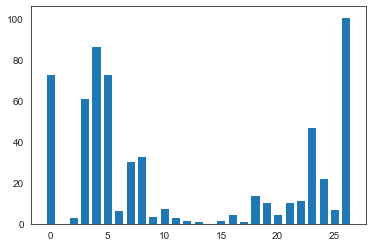

In [90]:
from sklearn.feature_selection import chi2, SelectKBest

# Separate continuous variables for this step, to be added back afterwards.
X_train_con = X_train.loc[:, ['age', 'fare', 'ticket_freq']]
X_train.drop(['age', 'fare', 'ticket_freq', 'ticket_freq'], axis=1, inplace=True)
# Separate continuous variables for this step, to be added back afterwards.
X_test_con = X_test.loc[:, ['age', 'fare', 'ticket_freq']]
X_test.drop(['age', 'fare', 'ticket_freq'], axis=1, inplace=True)
# Separate continuous variables for this step, to be added back afterwards.
df_test_trans_con = df_test_trans.loc[:, ['age', 'fare', 'ticket_freq']]
df_test_trans.drop(['age', 'fare', 'ticket_freq'], axis=1, inplace=True)

# Finally we scale our data - separately from categorical variables.
scaler = StandardScaler()

## Fit on training data set
# Random Forest performs better on un-scaled data.
names_training = list(X_train_con.columns.values)
_ = scaler.fit(X_train_con)
#X_train_new = scaler.transform(X_train_con)
#X_train_con = pd.DataFrame(X_train_new, columns=names_training)

# Apply to test data (training)
#X_test_new = scaler.transform(X_test_con)
#X_test_con = pd.DataFrame(X_test_new, columns=names_training)

# Scale age and fare on final dataset to final test data
#df_test_trans_new = scaler.transform(df_test_trans_con)
#df_test_trans_con = pd.DataFrame(df_test_trans_new, columns=names_training)

# Perform categorical feature selection
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)
df_test_trans =  df_test_trans.astype(float)

names_before_select = list(X_train.columns.values)
print("Categorical variables names: {}".format(names_before_select))
best_feat = SelectKBest(chi2, k=15).fit(X_train, y_train)
mask = X_train.columns.values[best_feat.get_support()]
X_train_new = best_feat.transform(X_train)
X_train = pd.DataFrame(X_train_new, columns=mask)

X_test_new = best_feat.transform(X_test)
X_test = pd.DataFrame(X_test_new, columns=mask)

df_test_trans_new = best_feat.transform(df_test_trans)
df_test_trans = pd.DataFrame(df_test_trans_new, columns=mask)

# What are scores for the features
for i in range(len(mask)):
	print('%s: \t\t\t\t%f' % (mask[i], best_feat.scores_[i]))

# plot the scores
_ = pyplot.bar([i for i in range(len(best_feat.scores_))], best_feat.scores_)
pyplot.show()

# Add continuous variables back again.
X_train = pd.merge(X_train, X_train_con[['age', 'fare', 'ticket_freq']], left_index=True,
                   right_index=True)
X_test = pd.merge(X_test, X_test_con[['age', 'fare', 'ticket_freq']], left_index=True,
                  right_index=True)
df_test_trans = pd.merge(df_test_trans, df_test_trans_con[['age', 'fare', 'ticket_freq']],
                  left_index=True, right_index=True)

In [91]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)
df_test_trans =  df_test_trans.astype(float)

Our final dataset for model building looks as follows:

In [92]:
X_train.head()


is_married  title_Miss  title_Mr  title_Mrs  p_class_3  fam_size_small  fam_size_very_large  fare_bin_above_average  fare_bin_high  deck_BDE_male  deck_FG_male  deck_M_male  deck_BDE_female  deck_FG_female  deck_M_female   age     fare  ticket_freq
0  0.0         0.0         1.0       0.0        1.0        0.0             0.0                  0.0                     0.0            0.0            0.0           1.0          0.0              0.0             0.0            28.0  7.8958   1.0        
1  0.0         1.0         0.0       0.0        1.0        0.0             0.0                  0.0                     0.0            0.0            0.0           0.0          0.0              1.0             0.0            17.0  7.9250   1.0        
2  0.0         0.0         1.0       0.0        1.0        1.0             0.0                  0.0                     0.0            0.0            0.0           1.0          0.0              0.0             0.0            30.0  16.1000  2.0        
3  0.0         0.0         1.0       0.0        1.0        0.0             0.0                  0.0                     0.0            0.0            1.0           0.0          0.0              0.0             0.0            22.0  7.2500   1.0        
4  1.0         0.0         0.0       1.0        0.0        0.0             0.0                  0.0                     0.0            0.0            0.0           0.0          0.0              0.0             1.0            45.0  13.5000  1.0

### Now we build a pipeline for modelling purposes.

In [93]:
cols_model = X_train.columns.to_list()
print(cols_model)

['is_married', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_3', 'fam_size_small', 'fam_size_very_large', 'fare_bin_above_average', 'fare_bin_high', 'deck_BDE_male', 'deck_FG_male', 'deck_M_male', 'deck_BDE_female', 'deck_FG_female', 'deck_M_female', 'age', 'fare', 'ticket_freq']


In [94]:
# Manually enter columns here for testing, need to automate this.
quantitative_cols_model = ['age', 'fare', 'ticket_freq']
categorical_cols_model = ['is_married', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_3',
                  'fam_size_small', 'fam_size_very_large', 'fare_bin_above_average',
                  'fare_bin_high', 'deck_BDE_male', 'deck_FG_male', 'deck_M_male',
                  'deck_BDE_female', 'deck_FG_female', 'deck_M_female']
all_cols_model = ['is_married', 'title_Miss', 'title_Mr', 'title_Mrs', 'p_class_3',
                  'fam_size_small', 'fam_size_very_large', 'fare_bin_above_average',
                  'fare_bin_high', 'deck_BDE_male', 'deck_FG_male', 'deck_M_male',
                  'deck_BDE_female', 'deck_FG_female', 'deck_M_female', 'age', 'fare',
                  'ticket_freq']

# Initial model
log_reg = LogisticRegression(max_iter=2000000, fit_intercept = False)

# We build our pipeline - same as before.
#num_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
#    ])

# Note - scikit-learn gives an error if you don't specify handle_unknown = "error" here. Need to come back to this.
#var_pipeline = ColumnTransformer(transformers = [
#        ("num", num_pipeline, quantitative_cols_model),
#       ("cat", OneHotEncoder(drop='first', handle_unknown='error'), categorical_cols),
#        ])

#pipeline = Pipeline(steps = [
#        ('var_prep', var_pipeline),
#        ('log_reg', log_reg),
#        ])

Now our final step, we build an automated ensemble of models.

In [95]:
X_train_numpy = X_train.to_numpy()
X_test_numpy = X_test.to_numpy()

ensemble = get_super_learner(X_train_numpy)
# fit the super learner
ensemble.fit(X_train_numpy, y_train)
# summarize base learners
print(ensemble.data)
# make predictions on hold out set
y_pred = ensemble.predict(X_test_numpy)
print('Super Learner: %.3f' % (accuracy_score(y_test, y_pred) * 100))

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=True,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_ex...24F5430>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=668,
       scorer=<function accuracy_score at 0x0000013E524F5430>,
       shuffle=True, verbose=False)

                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  adaboostclassifier           0.80     0.06  0.90  0.04  0.03  0.01
layer-1  baggingclassifier            0.80     0.04  0.25  0.02  0.01  0.00
layer-1  decisiontreeclassifier       0.75     0.05  0.02  0.00  0.00  0.00
layer-1  extratreesclassifier         0.77     0.05  0.27  0.03  0.01  0.00
layer-1  gaussiannb                   0.81     0.06  0.02  0.01  0.00  0.00
layer-1  kneighborsclassifier         0.68     0.08  0.01  0.00  0.02  0.00
layer-1  logisticregression           0.82     0.04  0.01  0.00  0.00  0.00
layer-1  randomforestclassifier       0.79     0.04  0.13  0.02  0.00  0.00
layer-1  svc                          0.66     0.04  0.07  0.01  0.00  0.00

Super Learner: 82.511


In [96]:
print('Ensemble: Accuracy %.3f' % (accuracy_score(y_test, y_pred)))

Ensemble: Accuracy 0.825


Looks good.

In [97]:
#data_pipeline = Pipeline(steps =
#                    [('var_prep', var_pipeline),
#                     ])
#
#X_train_pipe = data_pipeline.fit_transform(X_train)
#X_test_pipe = data_pipeline.transform(X_test)
#
#ensemble.fit(X_train_pipe, y_train)
#print(ensemble.data)
#y_pred = ensemble.predict(X_test_pipe)
#print('Ensemble: Accuracy %.3f' % (accuracy_score(y_test, y_pred)))


<h1 style = "font-family:verdana; background-color:#C5D6FA"><center>Conclusion
</center></h1>
<p><center style="color:#1F4BA7; font-family:cursive;">Discussion of results</center></p>

Previously we chose the optimised (regularised) MLP for submission based on overall
<i>public accuracy</i> score of 0.7799. This public score was in the top 24% and corresponds
more or less with our validation scores, so looks sensible! Not bad for a model with
absolutely no fine-tuning.

For this notebook we performed data cleaning and EDA. We spent a lot of time imputing
missing values and calculating correlation. We also spent some time doing some basic feature
 engineering. For this notebook the Random Forest model overtook the MLP in terms of
 performance, and scored a respectable public accuracy score of 0.79665! At this point we
 have used only hand-coded scikit-learn models, with no automated hyperparameter
 optimisation or fancy boosting models. Our approach is also different to other approaches
 on Kaggle in that we opted for the use of dummy variables only, given the fact that most
 variables in this problem are categorical. Seeing as we encoded all variables there was no
 need for scaling of values.

Not bad, but not a huge improvement taking into consideration all the time spent on data
cleaning and EDA...

We have however found some useful information from our Decision Trees regarding variable
interactions, and are confident that we can build some interesting cross-terms from these in
 our next notebook!

On to the next notebook on feature engineering and use of ML pipelines!

Hopefully we can crack the 80% level target by building some awesome cross-terms.
